In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

# Scrape Data

In [2]:
#Download s&p 500 data
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.','-') #to prevent errors with yfinance

symbols_list = sp500['Symbol'].unique().tolist() #it is not survivorship bias free

In [3]:
#Download data from yfinance

end_date = '2024-07-10'

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date)

df

[*********************100%%**********************]  503 of 503 completed


Price        Adj Close                                                 \
Ticker               A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2016-07-12   43.696865  33.309074   22.369740   45.996292         NaN   
2016-07-13   43.584179  33.107254   22.243452   45.882946         NaN   
2016-07-14   43.950428  34.481522   22.684320   45.068287         NaN   
2016-07-15   43.828346  34.491127   22.682022   44.855782         NaN   
2016-07-18   43.950428  34.625675   22.923126   45.025799         NaN   
...                ...        ...         ...         ...         ...   
2024-07-02  125.779999  11.050000  220.270004  164.449326  154.339996   
2024-07-03  126.129997  11.120000  221.550003  162.348618  152.729996   
2024-07-05  126.370003  11.040000  226.339996  165.727585  152.500000   
2024-07-08  126.070000  10.930000  227.820007  165.004227  151.960007   
2024-07-09  125.419998  10.980000  228.679993  166.520309  152.449997   

Price                                                                   ...  \
Ticker             ABT        ACGL         ACN        ADBE         ADI  ...   
Date                                                                    ...   
2016-07-12   36.462582   23.490000  102.284065   97.540001   50.380711  ...   
2016-07-13   36.255280   23.476667  102.573799   97.339996   50.833351  ...   
2016-07-14   36.523075   23.416668  102.521095   97.699997   51.260399  ...   
2016-07-15   36.367573   23.323334  101.046097   97.830002   51.371399  ...   
2016-07-18   36.358936   23.136667  100.212021   97.790001   51.610542  ...   
...                ...         ...         ...         ...         ...  ...   
2024-07-02  102.655380  100.000000  302.503357  567.710022  228.240005  ...   
2024-07-03  101.789978   97.650002  304.414978  570.150024  230.020004  ...   
2024-07-05  103.471054   98.150002  297.833862  578.340027  230.889999  ...   
2024-07-08  101.581085   98.260002  298.162384  575.400024  233.339996  ...   
2024-07-09  101.103615   98.000000  296.758545  566.020020  232.009995  ...   

Price       Volume                                                          \
Ticker         WTW       WY     WYNN      XEL       XOM      XYL       YUM   
Date                                                                         
2016-07-12  844000  5935000  2634100  4200300   9870800  1249300   6801851   
2016-07-13  630000  3668900  2037600  3601300   9458200   928700   8687491   
2016-07-14  567100  3646100  3453300  3825400   9293500  1204000  14672407   
2016-07-15  512200  3843700  1770700  3380600  10334500  1051500   5880453   
2016-07-18  462200  2910300  3102000  2836500   9865900   597500   4915933   
...            ...      ...      ...      ...       ...      ...       ...   
2024-07-02  268300  2769500  2233300  2661000  13326700   897200   2331500   
2024-07-03  194400  2549900  1556900  1178300   7732900   858200    935900   
2024-07-05  373600  5346200  1925200  1653000  12631000  1106300   1477600   
2024-07-08  321200  4055500  2239600  2245000  13350500   746800   1846100   
2024-07-09  397000  3734500  1830500  2240400  11727000   938700   1709400   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2016-07-12  1118271  688100  1824100  
2016-07-13  1086959  451100  2574300  
2016-07-14  1044832  684800  2617900  
2016-07-15   872204  754500  2089100  
2016-07-18  1216842  449000  2756800  
...             ...     ...      ...  
2024-07-02  1853500  212700  2454200  
2024-07-03   635900  106600  1251800  
2024-07-05  1045000  245700  1812100  
2024-07-08  1651100  209100  1704700  
2024-07-09  1360400  339000  1777500  

[2011 rows x 3018 columns]

In [4]:
df = df.stack()
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-12 A        43.696865   46.529999   46.660000   45.639999   45.770000   
           AAL      33.309074   34.660000   34.889999   32.750000   32.779999   
           AAPL     22.369740   24.355000   24.424999   24.280001   24.292500   
           ABBV     45.996292   65.500000   65.809998   64.320000   64.669998   
           ABT      36.462582   42.470001   42.650002   42.139999   42.340000   
...                       ...         ...         ...         ...         ...   
2024-07-09 XYL     133.589996  133.589996  134.619995  133.490005  134.100006   
           YUM     126.660004  126.660004  128.289993  126.589996  127.480003   
           ZBH     105.760002  105.760002  107.000000  105.370003  106.629997   
           ZBRA    315.239990  315.239990  321.160004  314.000000  314.910004   
           ZTS     173.826538  174.240005  175.729996  173.320007  175.690002   

Price                  volume  
date       ticker              
2016-07-12 A        2237700.0  
           AAL     25515700.0  
           AAPL    96670000.0  
           ABBV    11870500.0  
           ABT      8266200.0  
...                       ...  
2024-07-09 XYL       938700.0  
           YUM      1709400.0  
           ZBH      1360400.0  
           ZBRA      339000.0  
           ZTS      1777500.0  

[989933 rows x 6 columns]

# Calculate features and technical indicators for each stock

In [5]:
#Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2) - 1)*((np.log(df['adj close']) - np.log(df['open']))**2)

#RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

In [6]:
#Bolinger Bands

#df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

def calculate_bb(group, bb_type):
    if len(group) < 20:
        return pd.Series(index=group.index).fillna(np.nan)
    
    bb_result = pandas_ta.bbands(close=np.log1p(group), length=20)
    
    if bb_type == 0:  #Lower Band
        return bb_result.iloc[:, 0]
    elif bb_type == 1:  #Middle Band
        return bb_result.iloc[:, 1]
    elif bb_type == 2:  #Upper Band
        return bb_result.iloc[:, 2]

df['bb_low'] = df.groupby(level='ticker')['adj close'].transform(lambda x: calculate_bb(x, 0))

df['bb_mid'] = df.groupby(level='ticker')['adj close'].transform(lambda x: calculate_bb(x, 1))

df['bb_high'] = df.groupby(level='ticker')['adj close'].transform(lambda x: calculate_bb(x, 2))

In [7]:
#ATR

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    if atr is None or len(atr) == 0:
        return pd.Series(index=stock_data.index, dtype=float) #Return series of NaNs with the same index as input data
    return atr.sub(atr.mean()).div(atr.std()) #Normalize

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


In [8]:
#MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20)

    if macd is None or macd.empty:
        return pd.Series(index=close.index, dtype=float)
    
    macd_line = macd.iloc[:, 0]
    
    return (macd_line - macd_line.mean()) / macd_line.std()

df['macd'] = df.groupby(level='ticker')['adj close'].apply(compute_macd)

In [9]:
#Dollar volume
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

In [10]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-12 A        43.696865   46.529999   46.660000   45.639999   45.770000   
           AAL      33.309074   34.660000   34.889999   32.750000   32.779999   
           AAPL     22.369740   24.355000   24.424999   24.280001   24.292500   
           ABBV     45.996292   65.500000   65.809998   64.320000   64.669998   
           ABT      36.462582   42.470001   42.650002   42.139999   42.340000   
...                       ...         ...         ...         ...         ...   
2024-07-09 XYL     133.589996  133.589996  134.619995  133.490005  134.100006   
           YUM     126.660004  126.660004  128.289993  126.589996  127.480003   
           ZBH     105.760002  105.760002  107.000000  105.370003  106.629997   
           ZBRA    315.239990  315.239990  321.160004  314.000000  314.910004   
           ZTS     173.826538  174.240005  175.729996  173.320007  175.690002   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-07-12 A        2237700.0         -0.000586        NaN       NaN   
           AAL     25515700.0          0.001904        NaN       NaN   
           AAPL    96670000.0         -0.002609        NaN       NaN   
           ABBV    11870500.0         -0.044587        NaN       NaN   
           ABT      8266200.0         -0.008555        NaN       NaN   
...                       ...               ...        ...       ...   
2024-07-09 XYL       938700.0          0.000030  43.786449  4.884227   
           YUM      1709400.0          0.000073  29.943034  4.847699   
           ZBH      1360400.0          0.000092  33.720683  4.658990   
           ZBRA      339000.0          0.000254  56.496894  5.691595   
           ZTS      1777500.0          0.000051  53.330011  5.122228   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-12 A            NaN       NaN       NaN       NaN      97.780475  
           AAL          NaN       NaN       NaN       NaN     849.904350  
           AAPL         NaN       NaN       NaN       NaN    2162.482721  
           ABBV         NaN       NaN       NaN       NaN     545.998986  
           ABT          NaN       NaN       NaN       NaN     301.406992  
...                     ...       ...       ...       ...            ...  
2024-07-09 XYL     4.925902  4.967578  0.667634 -1.080742     125.400930  
           YUM     4.899032  4.950366  0.192883 -1.991390     216.512610  
           ZBH     4.686464  4.713937 -0.809035 -0.862015     143.875907  
           ZBRA    5.726408  5.761222 -0.319764  0.053437     106.866357  
           ZTS     5.157423  5.192617  0.563424  0.256450     308.976671  

[989933 rows x 14 columns]

# Aggregate to monthly level & filter top 150 most liquid stocks for each month (to reduce training time)

In [11]:
#Resample dollar volume to monthly average
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2016-07-31 A           76.142893
           AAL        412.618653
           AAPL      3431.108495
           ABBV       347.151137
           ABT        402.848464
...                          ...
2024-07-31 XYL        135.356987
           YUM        238.277085
           ZBH        163.471443
           ZBRA        71.645972
           ZTS        307.437821

[47761 rows x 1 columns]

In [12]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']] #list of indicators

df.unstack()[last_cols].resample('M').last().stack('ticker') #last value of monthly

Price               adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-07-31 A        45.180672       NaN       NaN       NaN       NaN   
           AAL      34.116329       NaN       NaN       NaN       NaN   
           AAPL     23.928867       NaN       NaN       NaN       NaN   
           ABBV     46.917210       NaN       NaN       NaN       NaN   
           ABT      38.656742       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2024-07-31 XYL     133.589996  0.667634  4.967578  4.884227  4.925902   
           YUM     126.660004  0.192883  4.950366  4.847699  4.899032   
           ZBH     105.760002 -0.809035  4.713937  4.658990  4.686464   
           ZBRA    315.239990 -0.319764  5.761222  5.691595  5.726408   
           ZTS     173.826538  0.563424  5.192617  5.122228  5.157423   

Price              garman_klass_vol      macd        rsi  
date       ticker                                         
2016-07-31 A              -0.000813       NaN        NaN  
           AAL            -0.000845       NaN        NaN  
           AAPL           -0.002745       NaN        NaN  
           ABBV           -0.041925       NaN        NaN  
           ABT            -0.007179       NaN        NaN  
...                             ...       ...        ...  
2024-07-31 XYL             0.000030 -1.080742  43.786449  
           YUM             0.000073 -1.991390  29.943034  
           ZBH             0.000092 -0.862015  33.720683  
           ZBRA            0.000254  0.053437  56.496894  
           ZTS             0.000051  0.256450  53.330011  

[47761 rows x 8 columns]

In [13]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
           axis=1)).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-08-31 A           87.662069   44.119469 -1.379455  3.842369  3.799092   
           AAL        269.710272   34.989563 -0.035314  3.624501  3.511263   
           AAPL      2718.975497   24.494831 -1.326343  3.275645  3.235305   
           ABBV       306.400103   45.408318 -1.527133  3.899057  3.835019   
           ABT        375.329275   36.298470 -1.202171  3.710207  3.624830   
...                          ...         ...       ...       ...       ...   
2024-07-31 XYL        135.356987  133.589996  0.667634  4.967578  4.884227   
           YUM        238.277085  126.660004  0.192883  4.950366  4.847699   
           ZBH        163.471443  105.760002 -0.809035  4.713937  4.658990   
           ZBRA        71.645972  315.239990 -0.319764  5.761222  5.691595   
           ZTS        307.437821  173.826538  0.563424  5.192617  5.122228   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-08-31 A       3.820731         -0.001640 -0.135019  47.813494  
           AAL     3.567882         -0.000479  0.523422  54.586618  
           AAPL    3.255475         -0.002162 -0.118495  56.079277  
           ABBV    3.867038         -0.046259 -0.279528  37.744038  
           ABT     3.667518         -0.010390 -0.320960  33.785606  
...                     ...               ...       ...        ...  
2024-07-31 XYL     4.925902          0.000030 -1.080742  43.786449  
           YUM     4.899032          0.000073 -1.991390  29.943034  
           ZBH     4.686464          0.000092 -0.862015  33.720683  
           ZBRA    5.726408          0.000254  0.053437  56.496894  
           ZTS     5.157423          0.000051  0.256450  53.330011  

[47256 rows x 9 columns]

In [14]:
#5 year rolling average of dollar volume for each stock
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

#ranking them
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-07-31 AAL      48.955441  0.805745  3.990058  3.892343  3.941200   
           AAPL     34.805626 -1.157042  3.616847  3.533293  3.575070   
           ABBV     51.445618 -1.285929  4.022419  3.959512  3.990966   
           ABT      43.532566 -1.331411  3.838591  3.753880  3.796236   
           ACN     115.462822 -1.253775  4.772708  4.707509  4.740108   
...                       ...       ...       ...       ...       ...   
2024-07-31 VZ       40.634998 -0.687584  3.745846  3.681926  3.713886   
           WFC      59.880001  0.524628  4.129548  4.045557  4.087552   
           WMT      69.900002  1.166698  4.262205  4.203281  4.232743   
           XOM     110.940002  0.447901  4.768706  4.693499  4.731102   
           ZTS     173.826538  0.563424  5.192617  5.122228  5.157423   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-07-31 AAL            -0.000281  0.308408  49.738343  
           AAPL           -0.002001 -0.184042  50.672232  
           ABBV           -0.038363 -0.110855  45.182740  
           ABT            -0.006503  0.296721  55.959114  
           ACN            -0.004393  0.092068  60.835358  
...                             ...       ...        ...  
2024-07-31 VZ             -0.000065  0.633239  55.868665  
           WFC             0.000246  0.188126  53.598083  
           WMT             0.000034  2.020048  67.670731  
           XOM             0.000147 -0.361802  43.097568  
           ZTS             0.000051  0.256450  53.330011  

[12665 rows x 8 columns]

# Calculate monthly return for different time horizons as features
#### (to capture dynamics like momentum patterns, we compute historical returns over various lag periods)

In [15]:
def calculate_returns(df):

    outlier_cutoff = 0.005 #99.5% for anomaly

    lags = [1,2,3,6,9,12] #months lags

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-07-31 AAL      38.702713  0.800958  3.699472  3.591910  3.645691   
           AAPL     45.223682 -1.080238  3.860463  3.808181  3.834322   
           ABBV     70.257530  0.041086  4.332605  4.225651  4.279128   
           ABT      59.123016 -0.945382  4.109713  4.015925  4.062819   
           ACN     145.464828 -0.840841  5.054037  4.993173  5.023605   
...                       ...       ...       ...       ...       ...   
2024-07-31 VRTX    485.989990  1.408720  6.187235  6.144153  6.165694   
           VZ       40.634998 -0.687584  3.745846  3.681926  3.713886   
           WFC      59.880001  0.524628  4.129548  4.045557  4.087552   
           WMT      69.900002  1.166698  4.262205  4.203281  4.232743   
           XOM     110.940002  0.447901  4.768706  4.693499  4.731102   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-07-31 AAL             0.000092 -0.290386  49.117700   0.041623   
           AAPL           -0.000885 -0.169934  52.605221   0.027983   
           ABBV           -0.027194 -0.727376  45.920939   0.005634   
           ABT            -0.003867  0.534185  62.882538   0.079433   
           ACN            -0.003530 -0.173561  42.887853  -0.026041   
...                             ...       ...        ...        ...   
2024-07-31 VRTX            0.000118  1.218179  65.548670   0.036845   
           VZ             -0.000065  0.633239  55.868665   0.001455   
           WFC             0.000246  0.188126  53.598083   0.008251   
           WMT             0.000034  2.020048  67.670731   0.032344   
           XOM             0.000147 -0.361802  43.097568  -0.036310   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310  
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-07-31 VRTX     0.033108   0.073532   0.019279   0.033234    0.027162  
           VZ       0.001821   0.015050  -0.001506   0.021857    0.020717  
           WFC     -0.000334   0.005056   0.032080   0.049035    0.024429  
           WMT      0.030998   0.057270   0.041691   0.029308    0.024076  
           XOM     -0.027322  -0.018458   0.015696   0.008190    0.005727  

[10506 rows x 14 columns]

# Download Fama-French factors & Calculate rolling factor betas

In [16]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data

Mkt-RF     SMB     HML     RMW     CMA
date                                              
2010-01-31 -0.0336  0.0034  0.0043 -0.0127  0.0046
2010-02-28  0.0340  0.0151  0.0323 -0.0027  0.0143
2010-03-31  0.0631  0.0185  0.0221 -0.0065  0.0169
2010-04-30  0.0200  0.0498  0.0289  0.0069  0.0172
2010-05-31 -0.0789  0.0004 -0.0244  0.0130 -0.0021
...            ...     ...     ...     ...     ...
2024-01-31  0.0070 -0.0574 -0.0238  0.0069 -0.0095
2024-02-29  0.0506 -0.0078 -0.0349 -0.0199 -0.0214
2024-03-31  0.0283 -0.0116  0.0420  0.0149  0.0117
2024-04-30 -0.0467 -0.0255 -0.0052  0.0149 -0.0030
2024-05-31  0.0434  0.0059 -0.0133  0.0321 -0.0287

[173 rows x 5 columns]

In [17]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005634
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10222 rows x 6 columns]

In [18]:
#Filter stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005634
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10180 rows x 6 columns]

In [19]:
#Calculate rolling factor betas
betas = (factor_data.groupby(level=1, group_keys=False)
        .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                    exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                    window=min(24, x.shape[0]),
                                    min_nobs=len(x.columns)+1)
        .fit(params_only=True)
        .params
        .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392347  0.763705 -0.574362  0.647316  0.505625
           VZ      0.484128 -0.864954  0.243820  0.220609  0.058601
           WFC     1.081662  0.184095  1.299962 -0.616454 -0.772451
           WMT     0.573128 -0.030581  0.000609  0.770717 -0.001393
           XOM     0.797737 -0.087301  0.436583  0.739679  0.542566

[10180 rows x 5 columns]

In [20]:
data = (data.join(betas.groupby('ticker').shift())) #shift by 1 before joining because we know them the next month

In [21]:
#Fixing the missing values problem
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10306 entries, (Timestamp('2018-07-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2024-07-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10306 non-null  float64
 1   bb_high           10306 non-null  float64
 2   bb_low            10306 non-null  float64
 3   bb_mid            10306 non-null  float64
 4   garman_klass_vol  10306 non-null  float64
 5   macd              10306 non-null  float64
 6   rsi               10306 non-null  float64
 7   return_1m         10306 non-null  float64
 8   return_2m         10306 non-null  float64
 9   return_3m         10306 non-null  float64
 10  return_6m         10306 non-null  float64
 11  return_9m         10306 non-null  float64
 12  return_12m        10306 non-null  float64
 13  Mkt-RF            10306 non-null  float64
 14  SMB               10306 non-null  floa

### These are the features, now using them for predictions

# Fit K-Means Clustering Algo for each month to group similar assets based on their features

In [22]:
from sklearn.cluster import KMeans

def get_clusters_1(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters_1)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-07-31 AAL     0.800958  3.699472  3.591910  3.645691          0.000092   
           AAPL   -1.080238  3.860463  3.808181  3.834322         -0.000885   
           ABBV    0.041086  4.332605  4.225651  4.279128         -0.027194   
           ABT    -0.945382  4.109713  4.015925  4.062819         -0.003867   
           ACN    -0.840841  5.054037  4.993173  5.023605         -0.003530   
...                     ...       ...       ...       ...               ...   
2024-07-31 VRTX    1.408720  6.187235  6.144153  6.165694          0.000118   
           VZ     -0.687584  3.745846  3.681926  3.713886         -0.000065   
           WFC     0.524628  4.129548  4.045557  4.087552          0.000246   
           WMT     1.166698  4.262205  4.203281  4.232743          0.000034   
           XOM     0.447901  4.768706  4.693499  4.731102          0.000147   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-07-31 AAL    -0.290386  49.117700   0.041623  -0.047041  -0.026289   
           AAPL   -0.169934  52.605221   0.027983   0.009109   0.049478   
           ABBV   -0.727376  45.920939   0.005634  -0.029587  -0.011801   
           ABT     0.534185  62.882538   0.079433   0.034389   0.042361   
           ACN    -0.173561  42.887853  -0.026041   0.011460   0.017611   
...                     ...        ...        ...        ...        ...   
2024-07-31 VRTX    1.218179  65.548670   0.036845   0.033108   0.073532   
           VZ      0.633239  55.868665   0.001455   0.001821   0.015050   
           WFC     0.188126  53.598083   0.008251  -0.000334   0.005056   
           WMT     2.020048  67.670731   0.032344   0.030998   0.057270   
           XOM    -0.361802  43.097568  -0.036310  -0.027322  -0.018458   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202351  1.530399   
           AAPL     0.022909   0.014540    0.022060  1.318289 -0.329360   
           ABBV    -0.028860   0.005495    0.026310  0.477699  0.507593   
           ABT      0.010427   0.022867    0.025837  0.787039 -0.128993   
           ACN      0.000037   0.013581    0.019435  1.213825 -0.190195   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.019279   0.033234    0.027162  0.509072  0.092526   
           VZ      -0.001506   0.021857    0.020717  0.468968 -0.455634   
           WFC      0.032080   0.049035    0.024429  1.087872 -0.099205   
           WMT      0.041691   0.029308    0.024076  0.616885 -0.391018   
           XOM      0.015696   0.008190    0.005727  1.068892  0.144629   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397098  0.197188  0.824601        0  
           AAPL   -0.628102  0.427306  0.622959        1  
           ABBV   -0.202950  0.535458  0.469461        0  
           ABT    -0.439231  0.243586  0.934216        2  
           ACN    -0.253432  0.340776  0.082098        0  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.891222  0.067718  0.853537        2  
           VZ      0.229411  0.187555  0.226241        1  
           WFC     1.566561 -0.737993 -0.867371        1  
           WMT    -0.373266  0.212561  0.684857        2  
           XOM     0.842900 -0.485051  0.435615        0  

[10306 rows x 19 columns]

In [23]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    #Plot according to atr (x) and rsi (y) just for visualization
    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    
    return

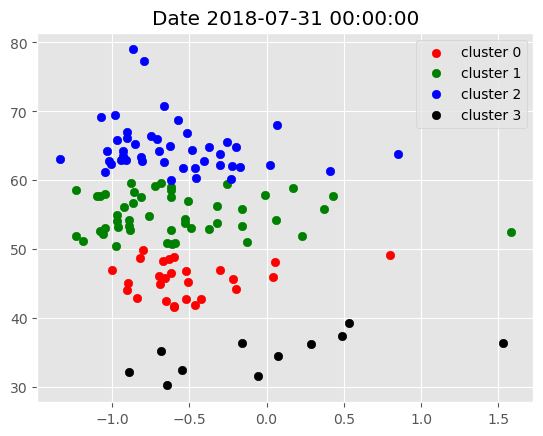

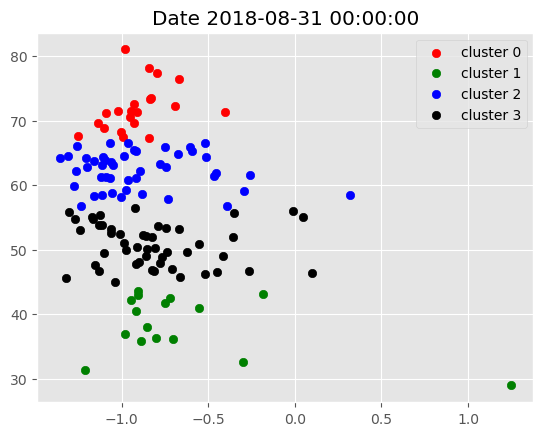

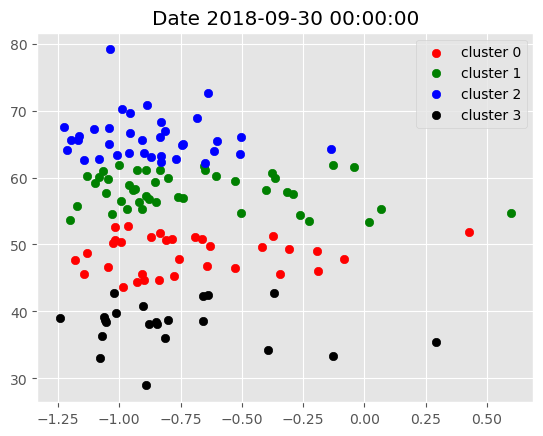

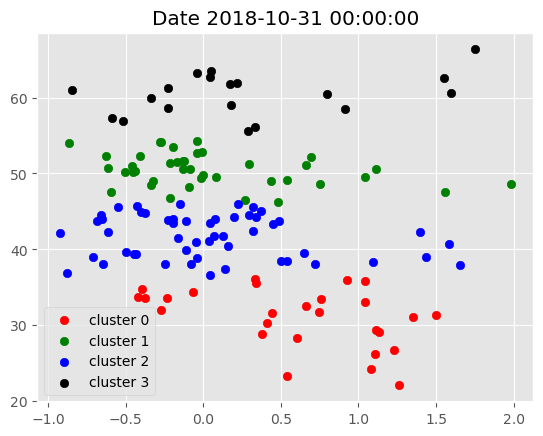

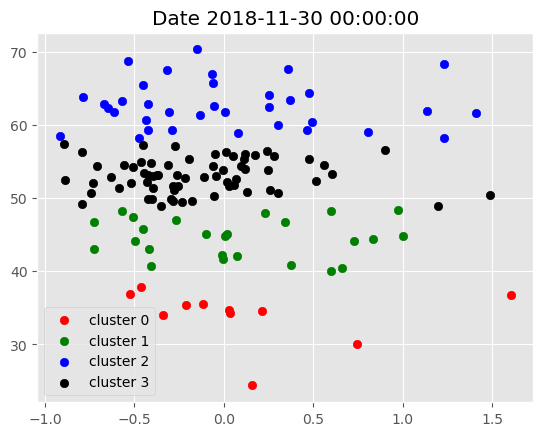

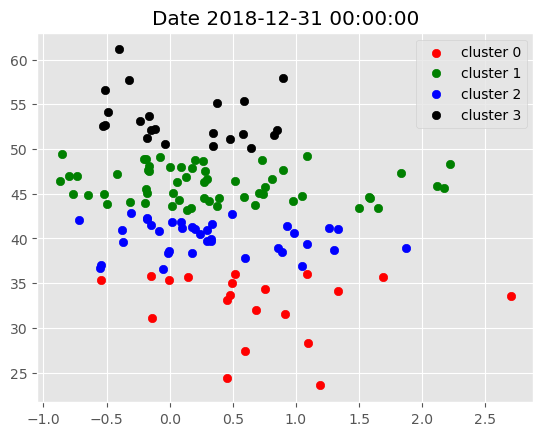

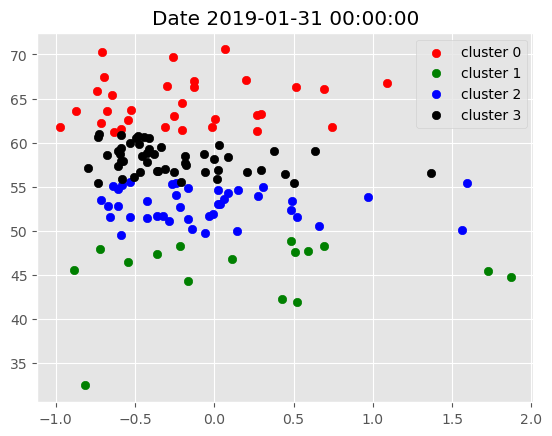

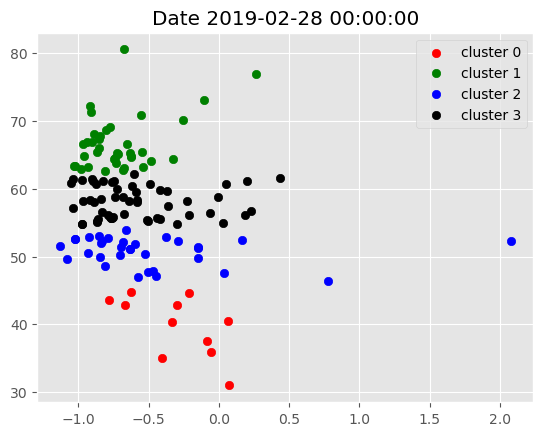

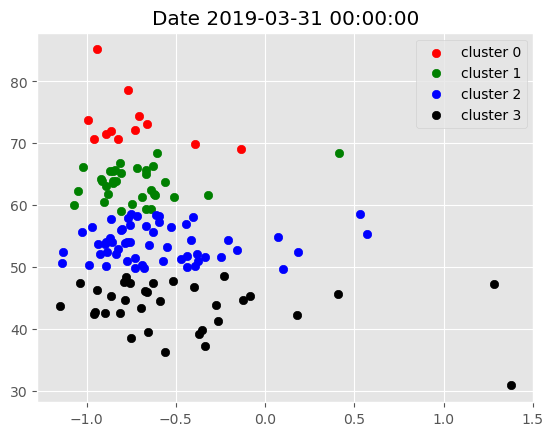

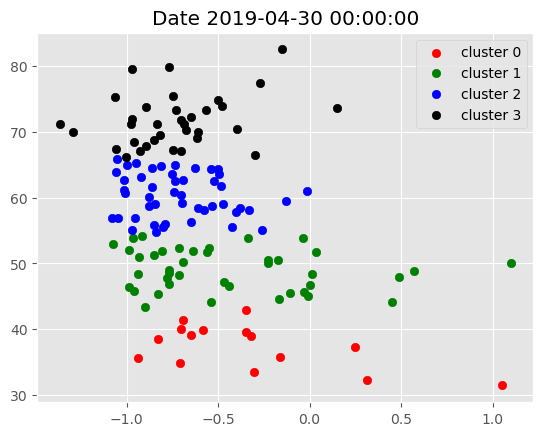

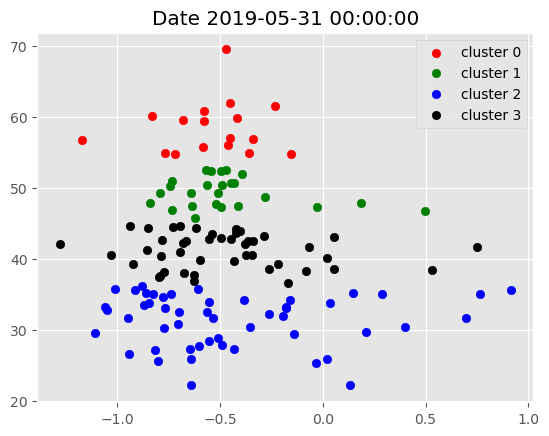

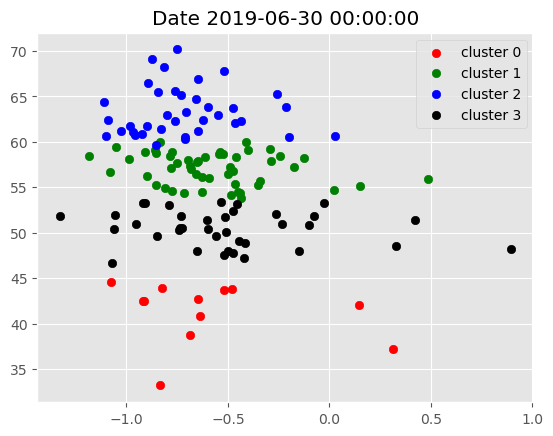

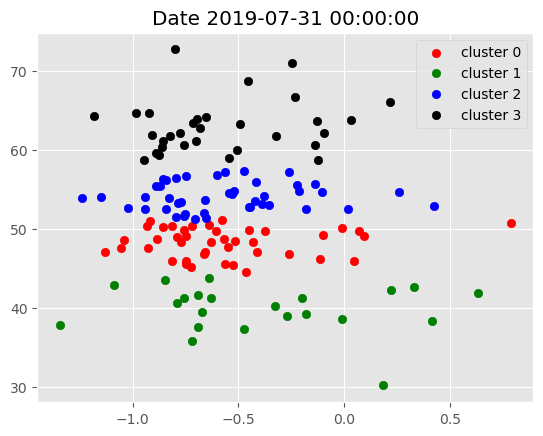

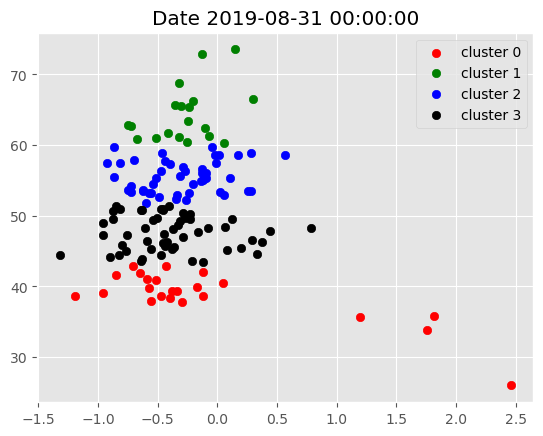

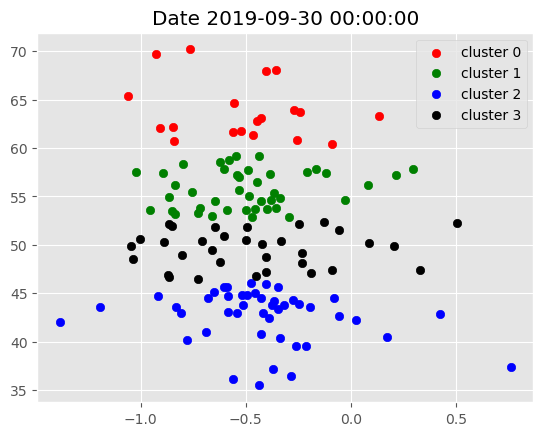

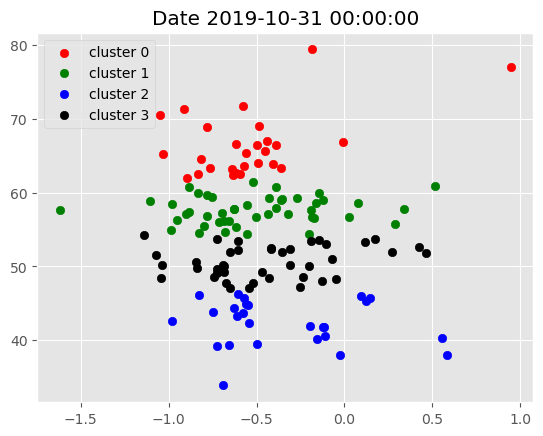

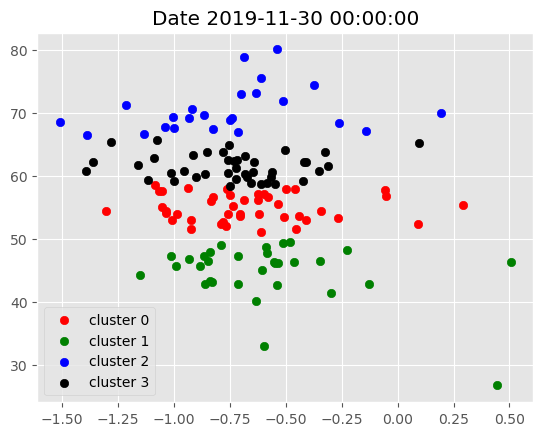

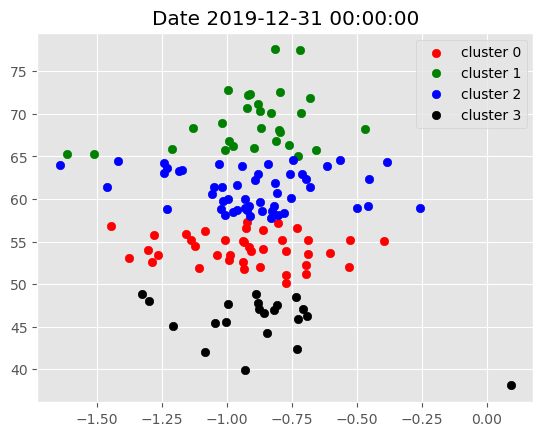

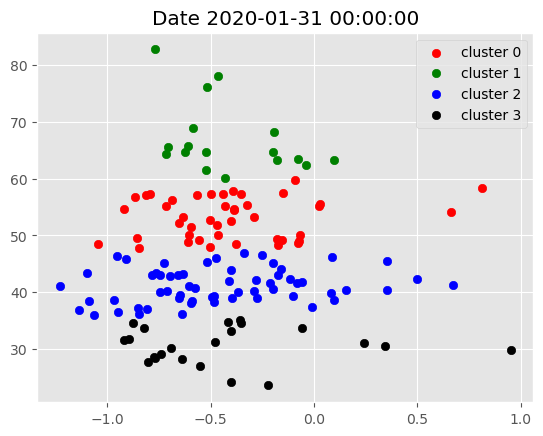

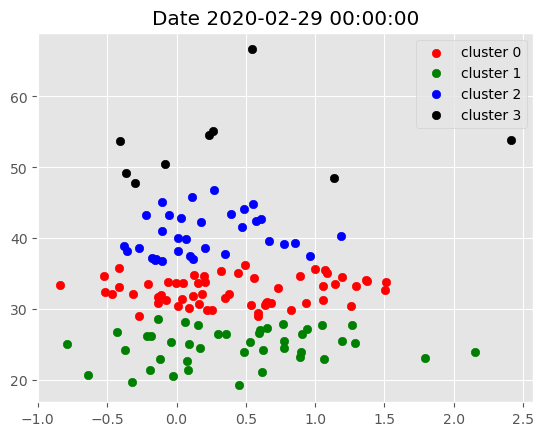

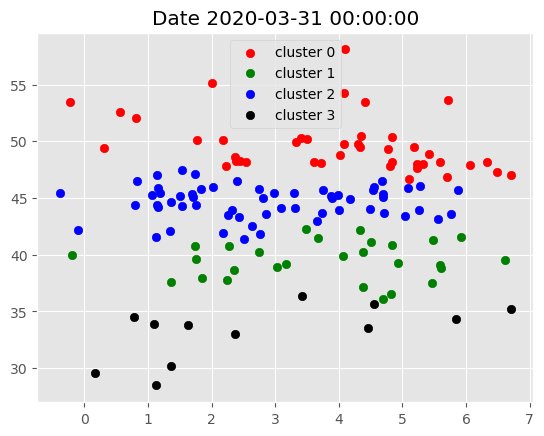

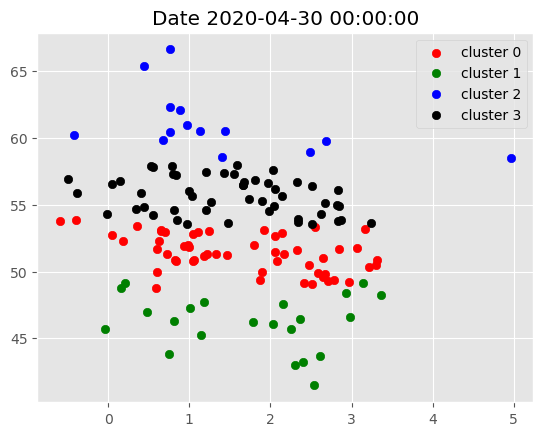

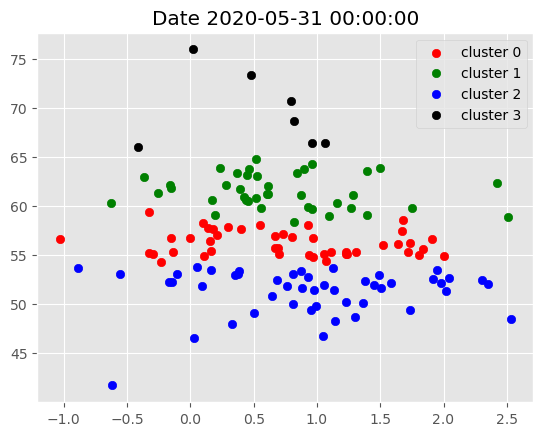

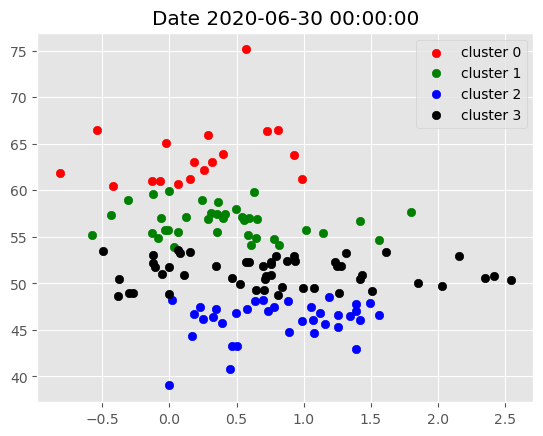

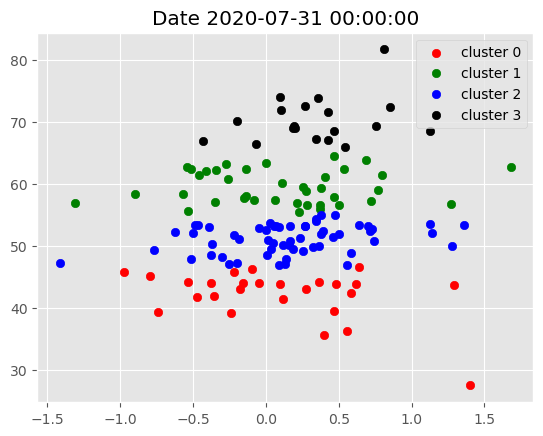

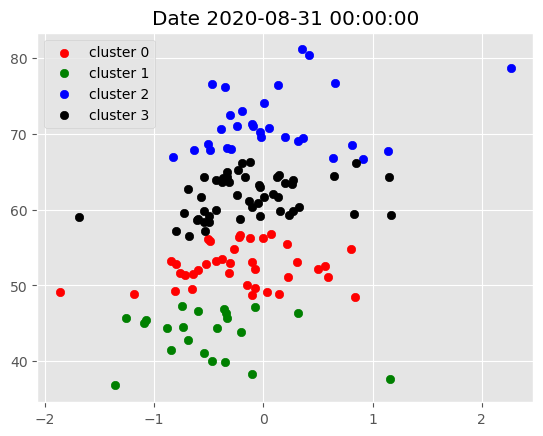

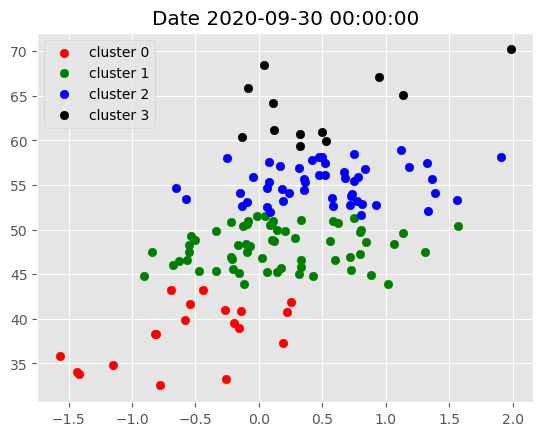

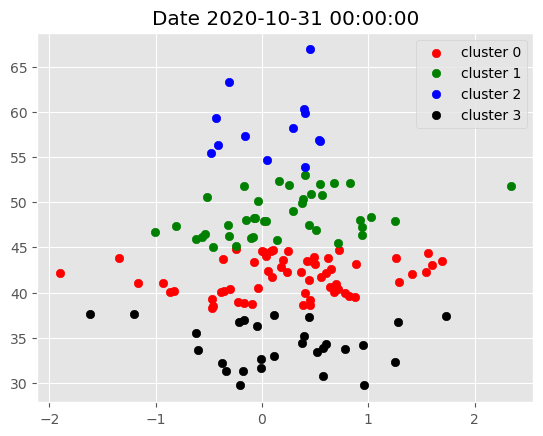

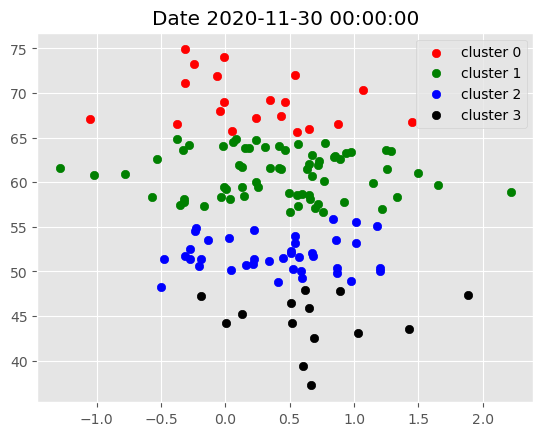

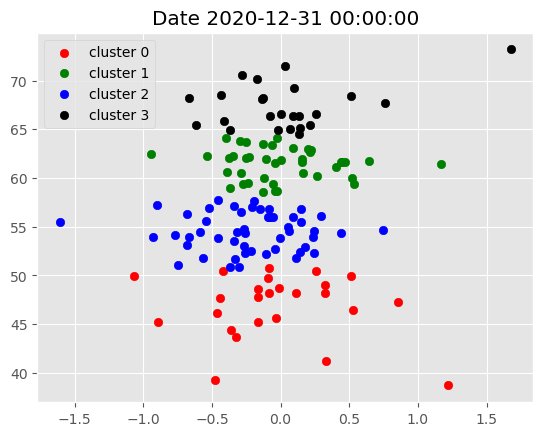

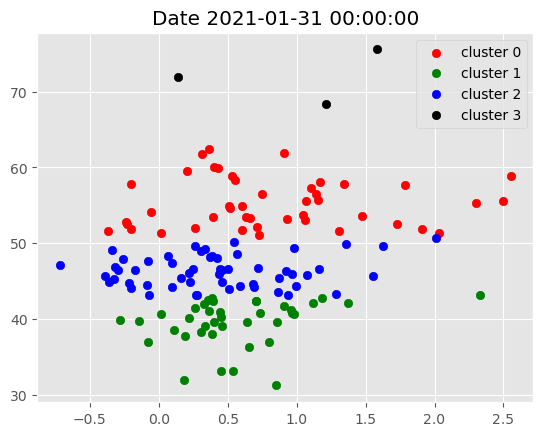

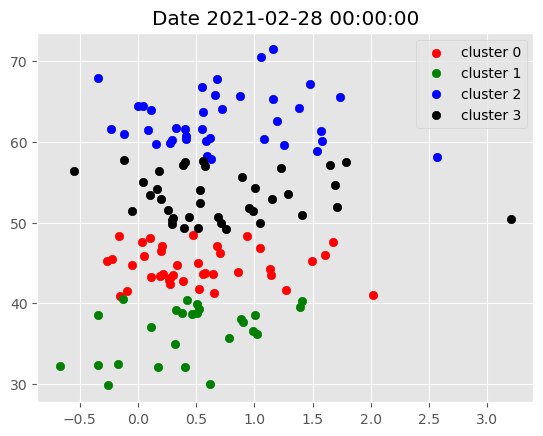

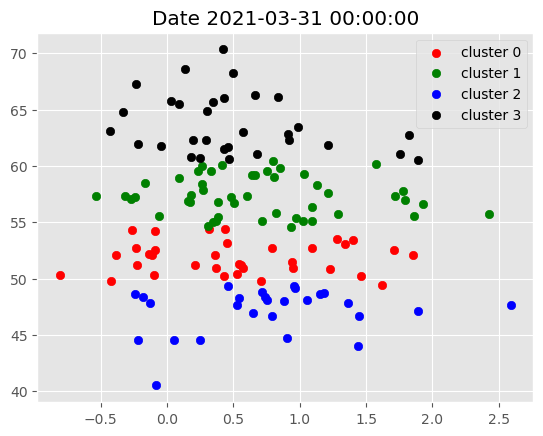

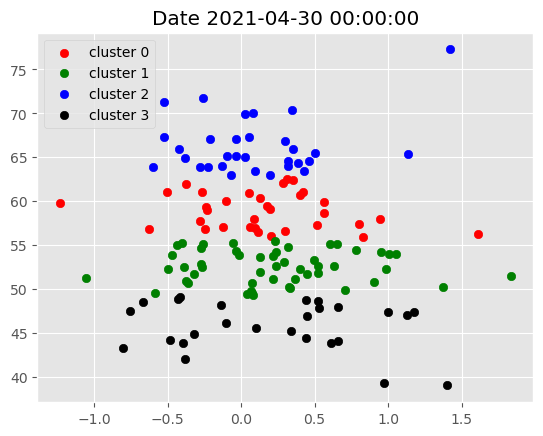

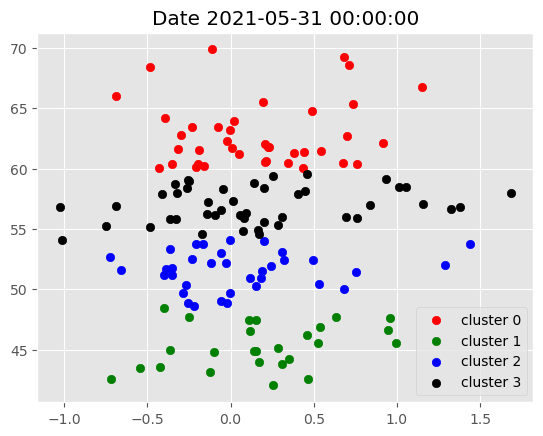

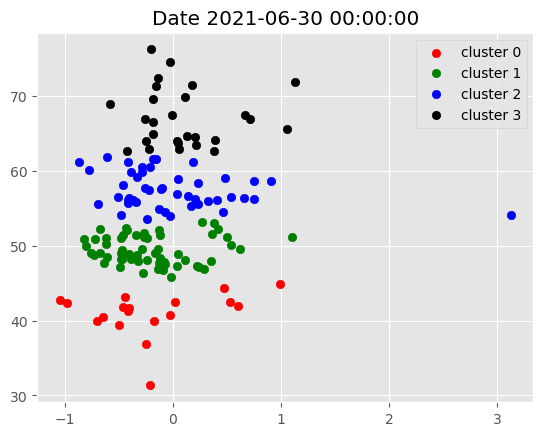

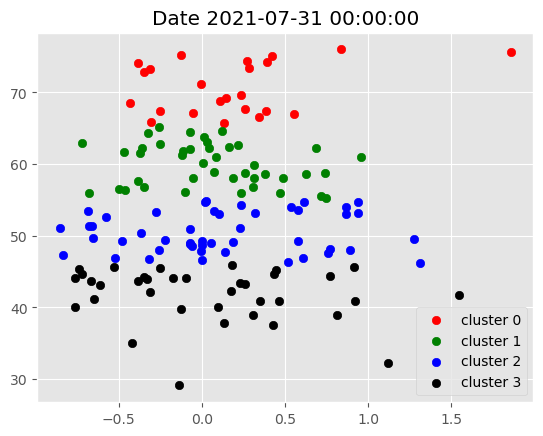

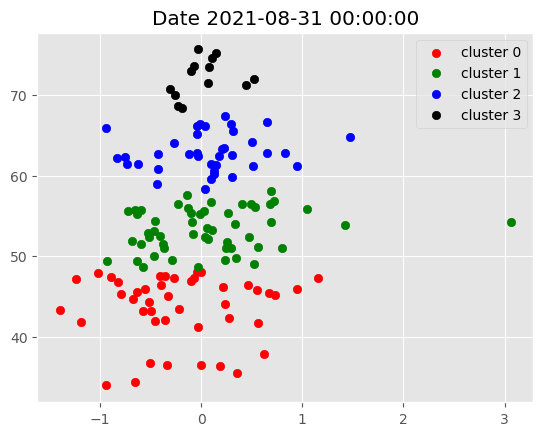

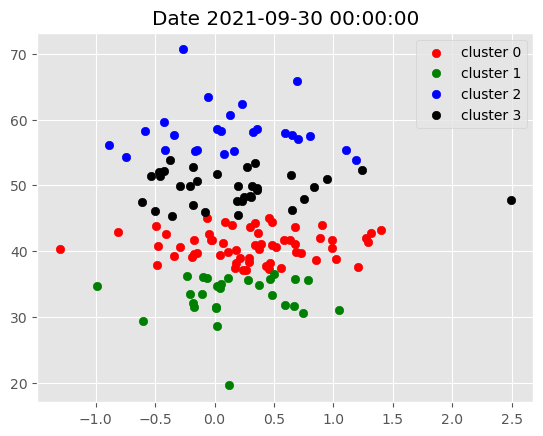

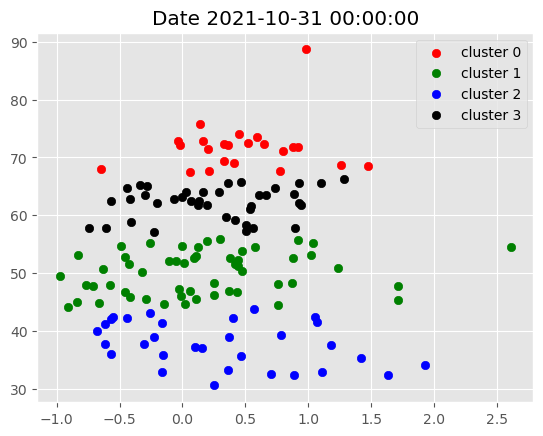

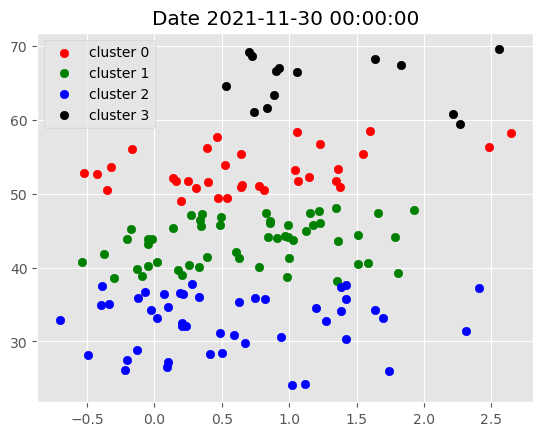

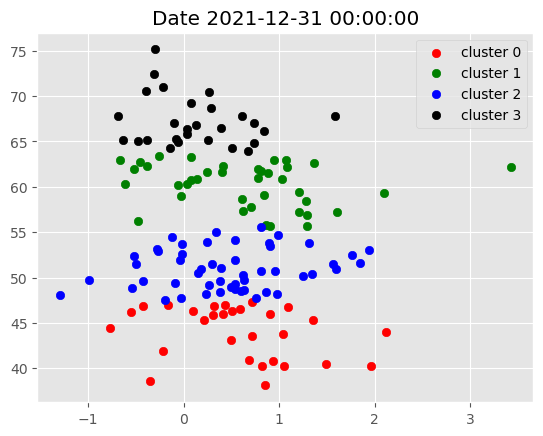

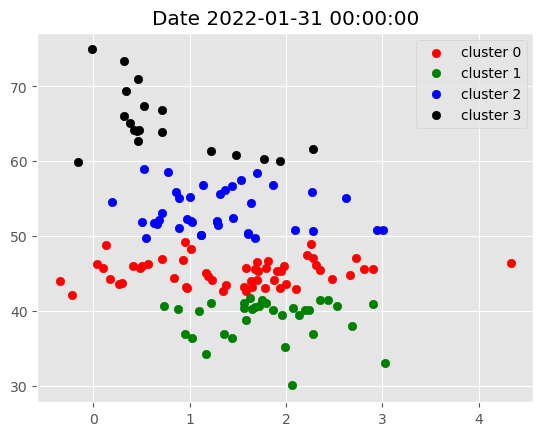

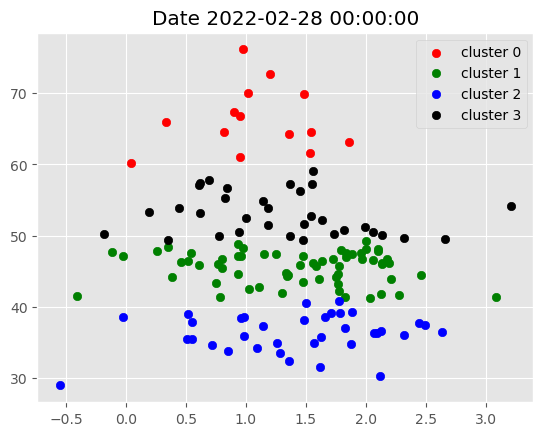

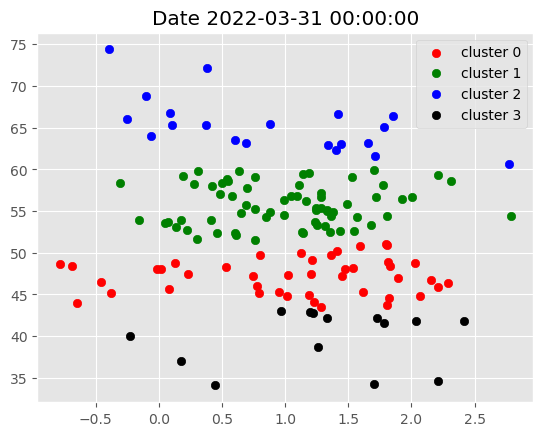

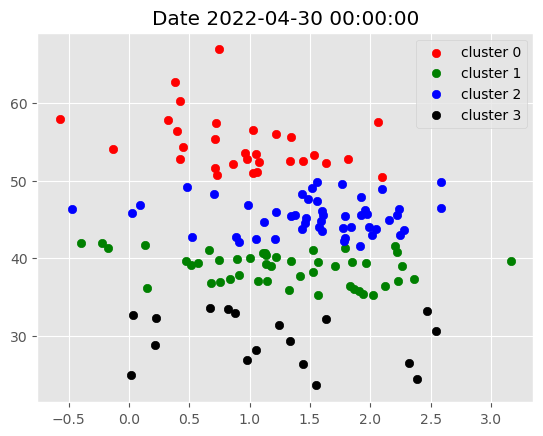

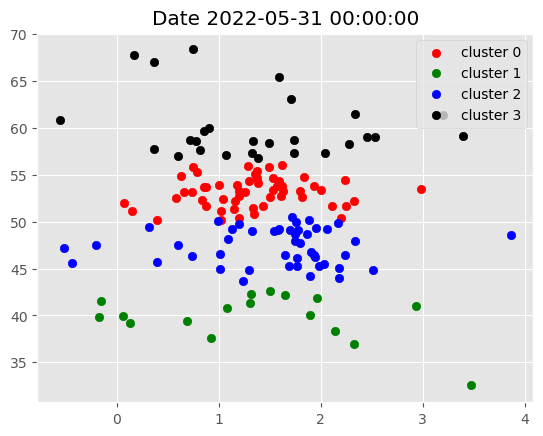

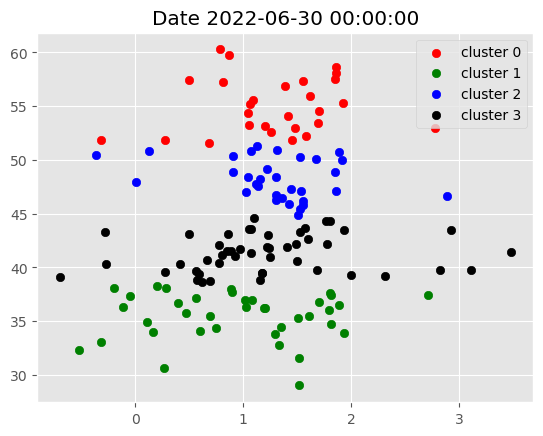

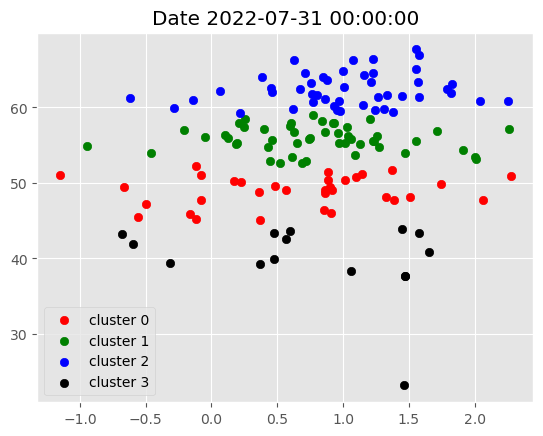

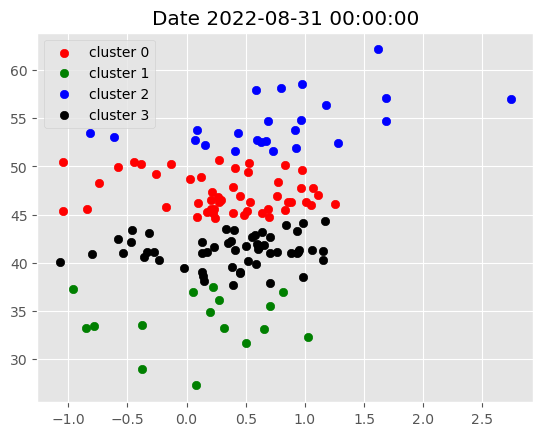

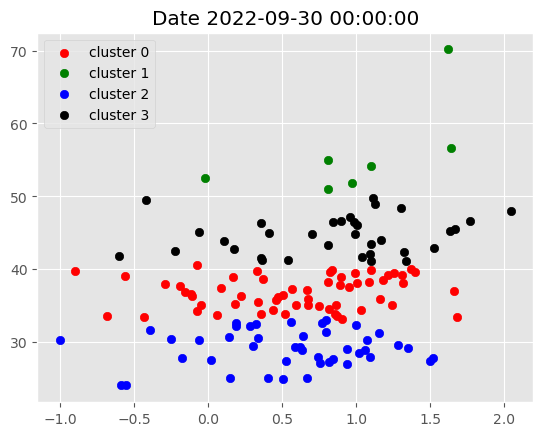

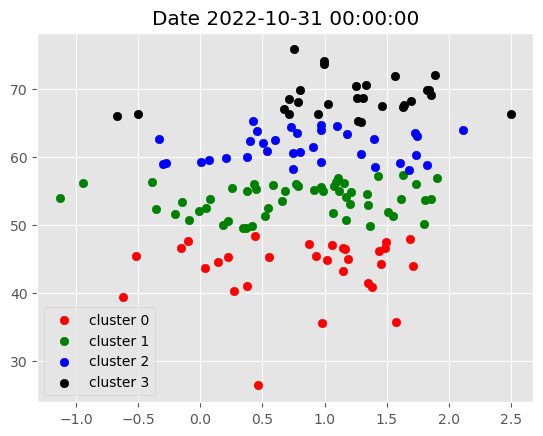

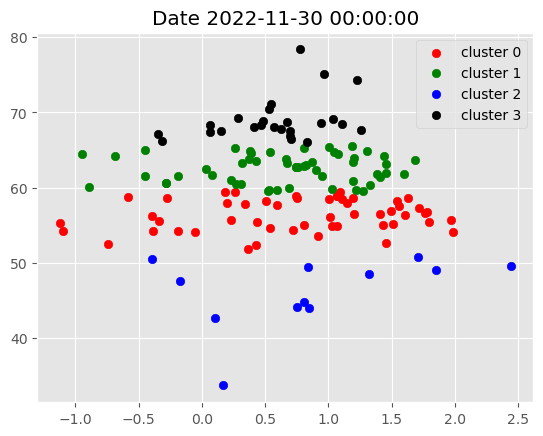

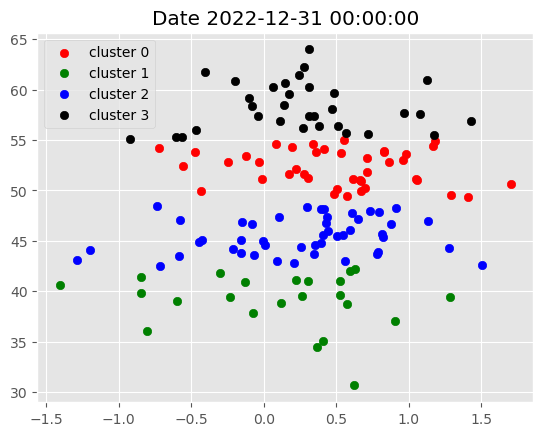

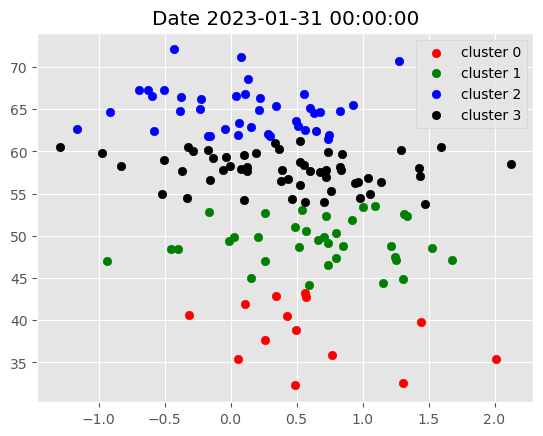

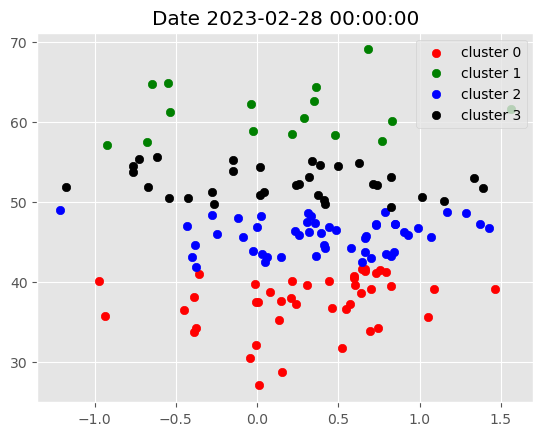

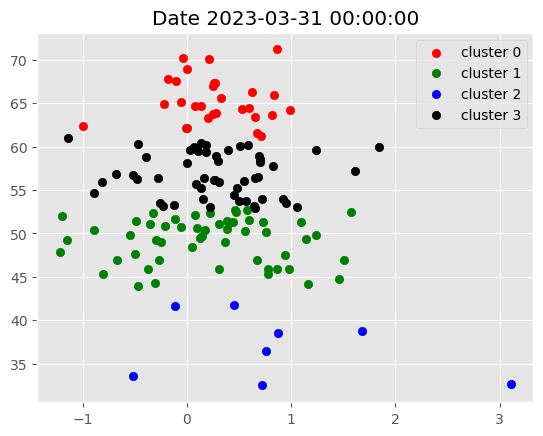

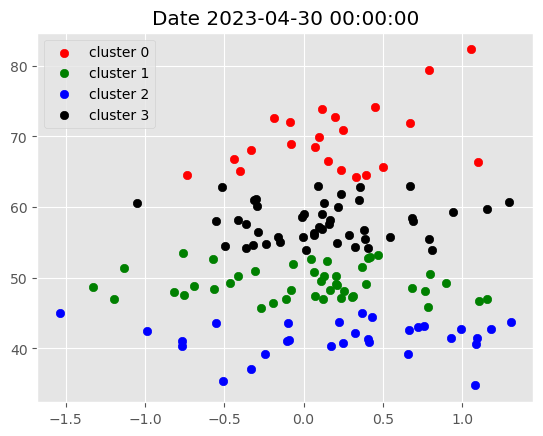

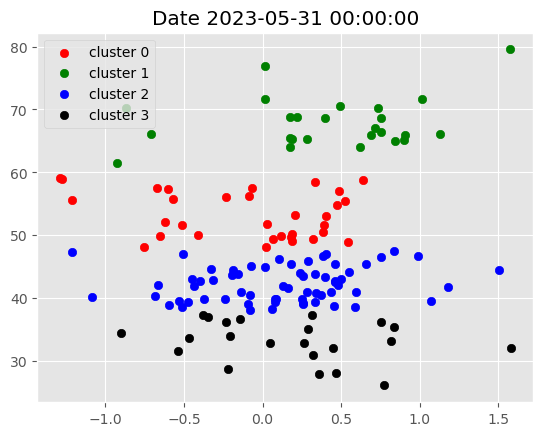

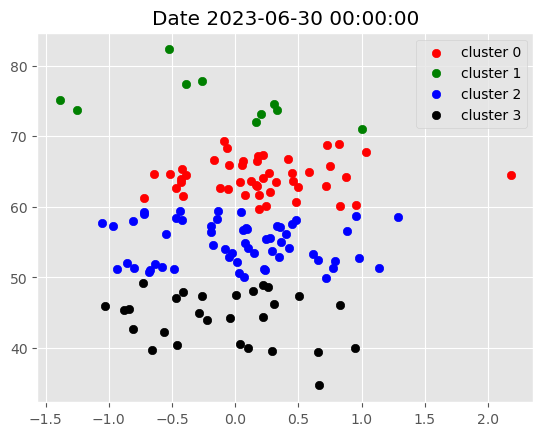

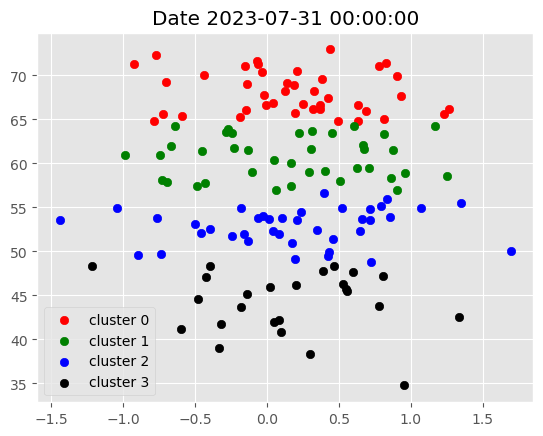

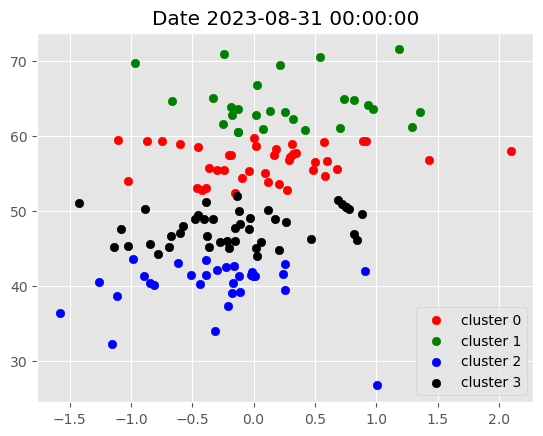

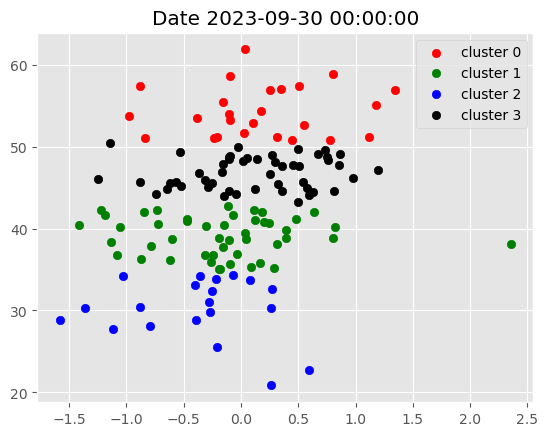

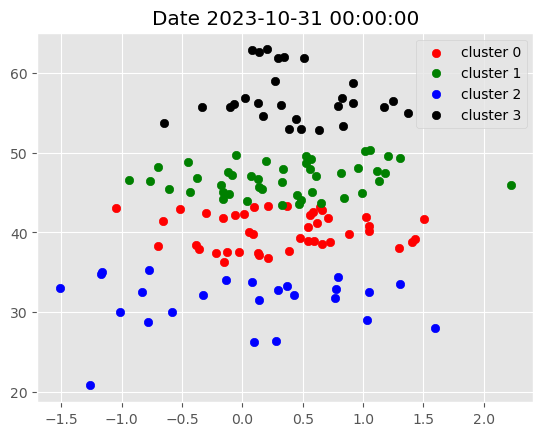

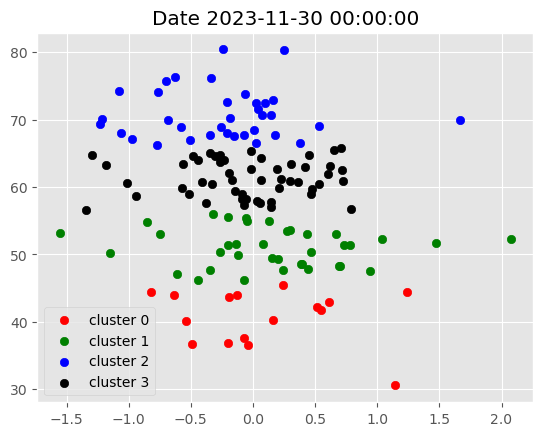

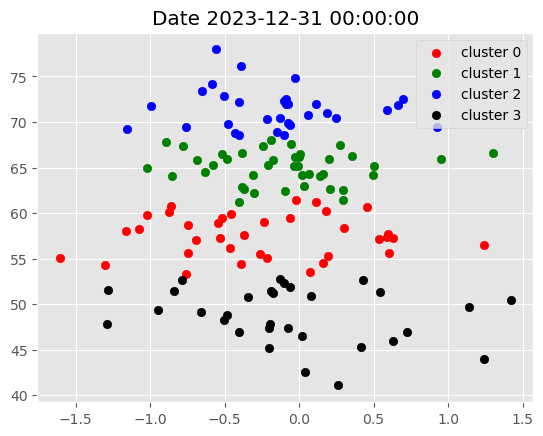

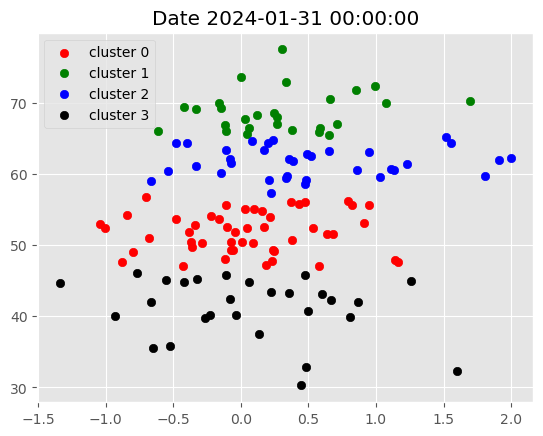

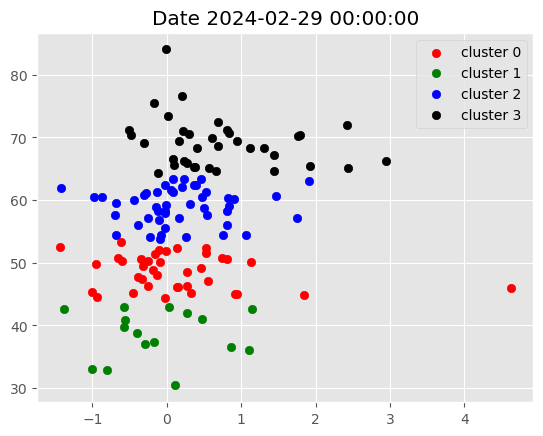

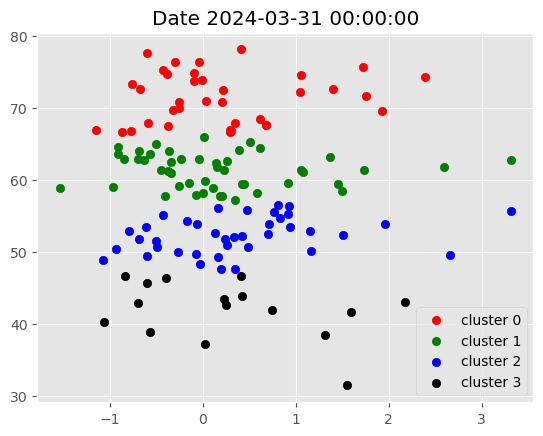

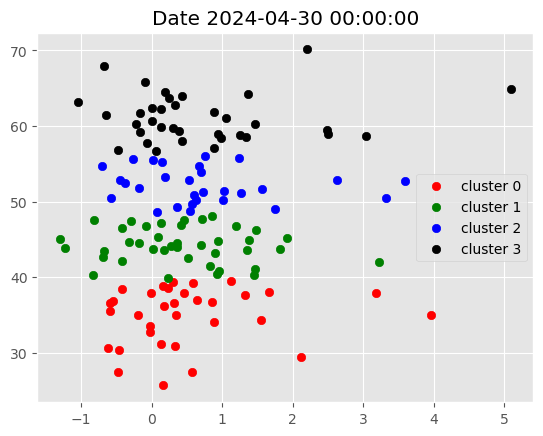

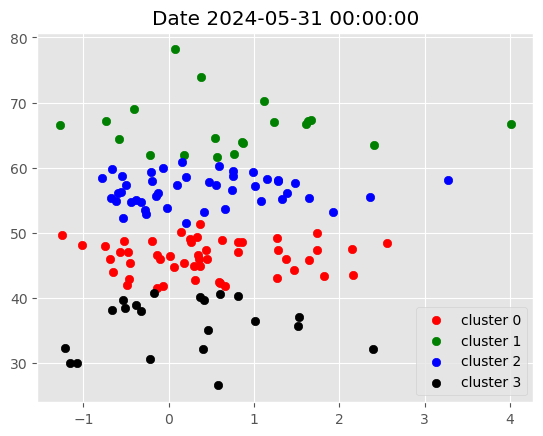

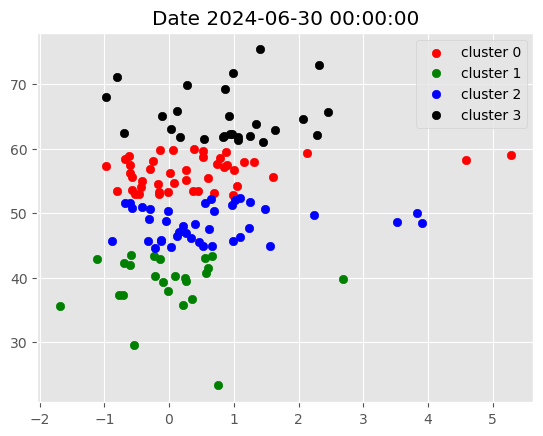

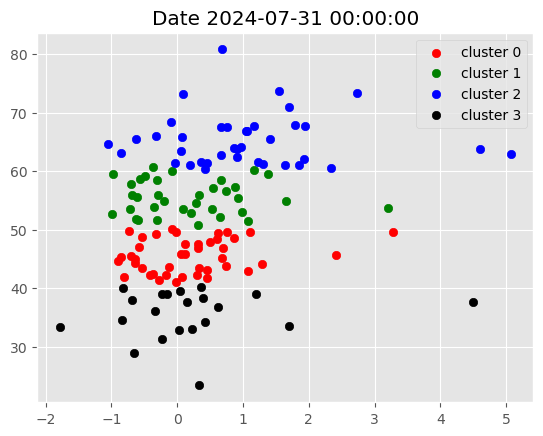

In [24]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

#The problem with plots is that the clusters are not around the same range for each date
#For example, cluster blue stays on top for a few days but gets to the bottom on some days and similarly for other clusters

In [25]:
#Apply pre defined centroids to solve the problem
target_rsi_values = [30,45,55,70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-07-31 AAL     0.800958  3.699472  3.591910  3.645691          0.000092   
           AAPL   -1.080238  3.860463  3.808181  3.834322         -0.000885   
           ABBV    0.041086  4.332605  4.225651  4.279128         -0.027194   
           ABT    -0.945382  4.109713  4.015925  4.062819         -0.003867   
           ACN    -0.840841  5.054037  4.993173  5.023605         -0.003530   
...                     ...       ...       ...       ...               ...   
2024-07-31 VRTX    1.408720  6.187235  6.144153  6.165694          0.000118   
           VZ     -0.687584  3.745846  3.681926  3.713886         -0.000065   
           WFC     0.524628  4.129548  4.045557  4.087552          0.000246   
           WMT     1.166698  4.262205  4.203281  4.232743          0.000034   
           XOM     0.447901  4.768706  4.693499  4.731102          0.000147   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-07-31 AAL    -0.290386  49.117700   0.041623  -0.047041  -0.026289   
           AAPL   -0.169934  52.605221   0.027983   0.009109   0.049478   
           ABBV   -0.727376  45.920939   0.005634  -0.029587  -0.011801   
           ABT     0.534185  62.882538   0.079433   0.034389   0.042361   
           ACN    -0.173561  42.887853  -0.026041   0.011460   0.017611   
...                     ...        ...        ...        ...        ...   
2024-07-31 VRTX    1.218179  65.548670   0.036845   0.033108   0.073532   
           VZ      0.633239  55.868665   0.001455   0.001821   0.015050   
           WFC     0.188126  53.598083   0.008251  -0.000334   0.005056   
           WMT     2.020048  67.670731   0.032344   0.030998   0.057270   
           XOM    -0.361802  43.097568  -0.036310  -0.027322  -0.018458   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202351  1.530399   
           AAPL     0.022909   0.014540    0.022060  1.318289 -0.329360   
           ABBV    -0.028860   0.005495    0.026310  0.477699  0.507593   
           ABT      0.010427   0.022867    0.025837  0.787039 -0.128993   
           ACN      0.000037   0.013581    0.019435  1.213825 -0.190195   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.019279   0.033234    0.027162  0.509072  0.092526   
           VZ      -0.001506   0.021857    0.020717  0.468968 -0.455634   
           WFC      0.032080   0.049035    0.024429  1.087872 -0.099205   
           WMT      0.041691   0.029308    0.024076  0.616885 -0.391018   
           XOM      0.015696   0.008190    0.005727  1.068892  0.144629   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397098  0.197188  0.824601        1  
           AAPL   -0.628102  0.427306  0.622959        2  
           ABBV   -0.202950  0.535458  0.469461        1  
           ABT    -0.439231  0.243586  0.934216        3  
           ACN    -0.253432  0.340776  0.082098        1  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.891222  0.067718  0.853537        3  
           VZ      0.229411  0.187555  0.226241        2  
           WFC     1.566561 -0.737993 -0.867371        2  
           WMT    -0.373266  0.212561  0.684857        3  
           XOM     0.842900 -0.485051  0.435615        1  

[10306 rows x 19 columns]

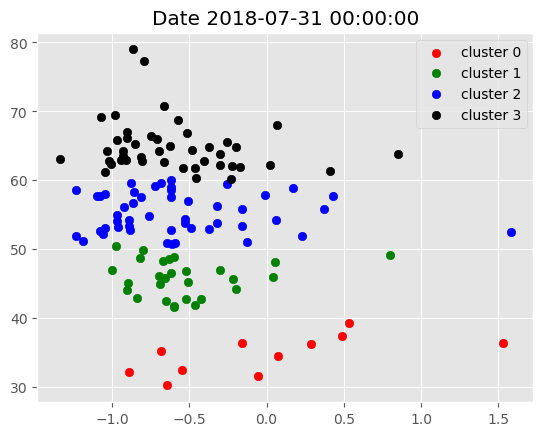

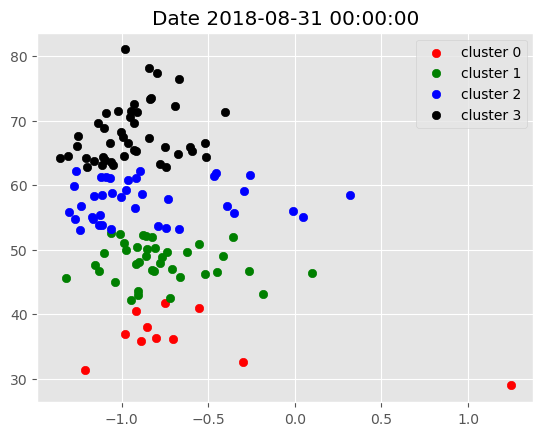

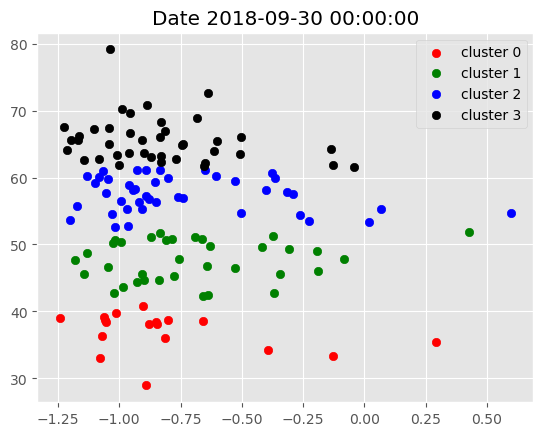

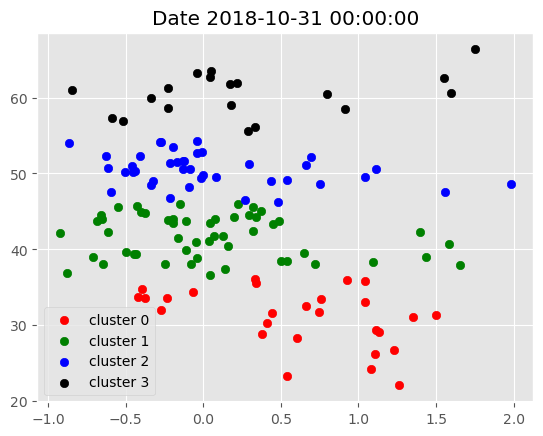

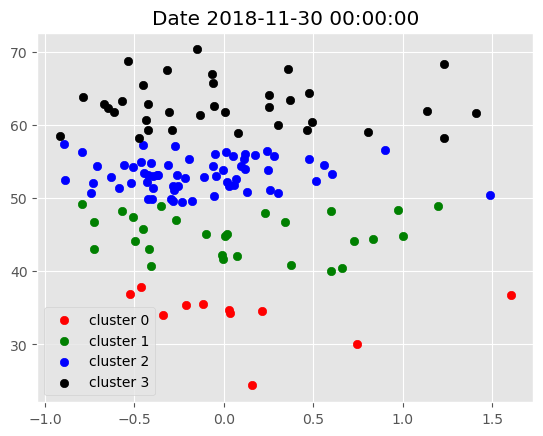

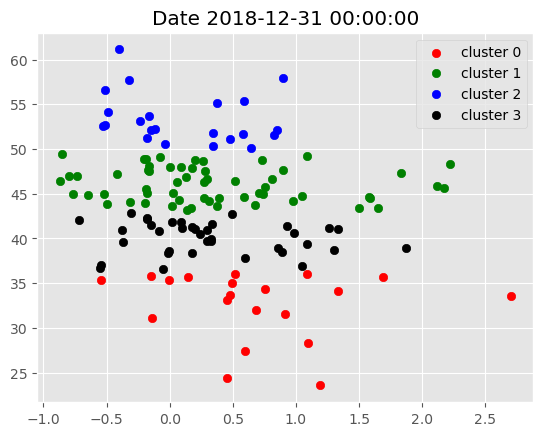

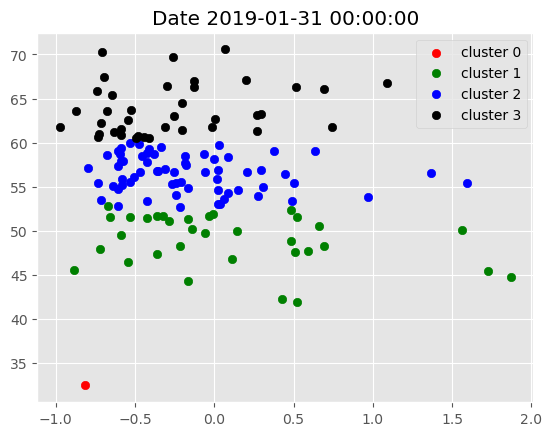

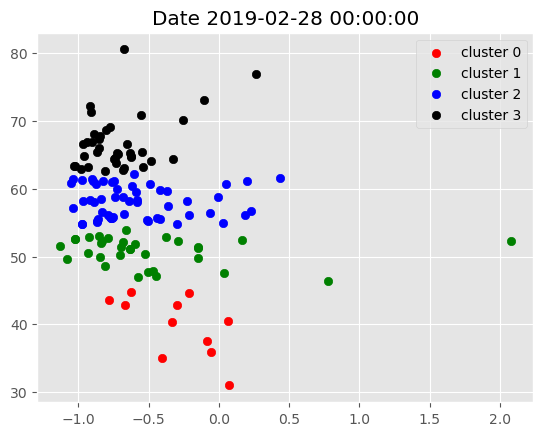

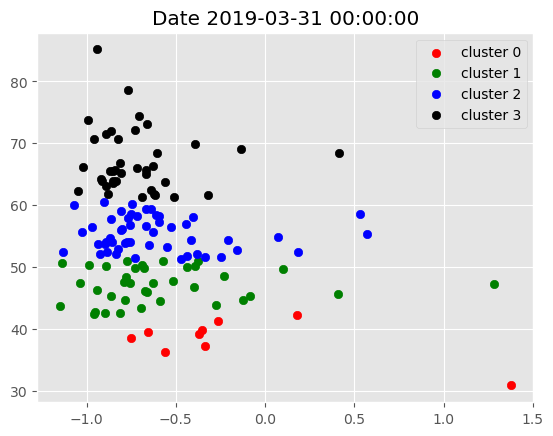

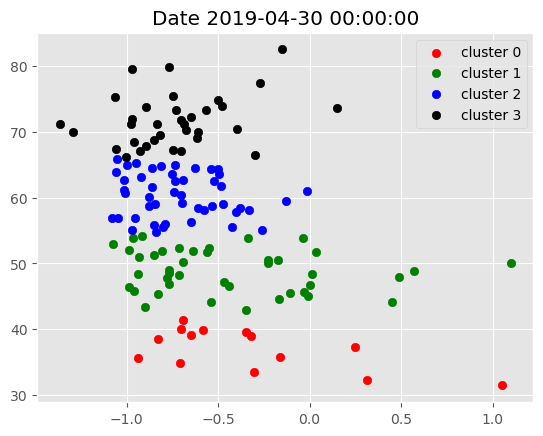

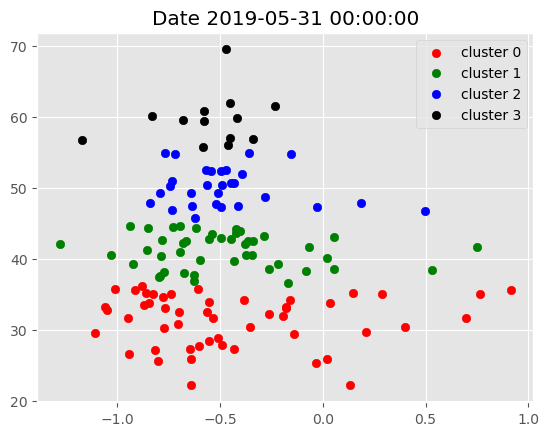

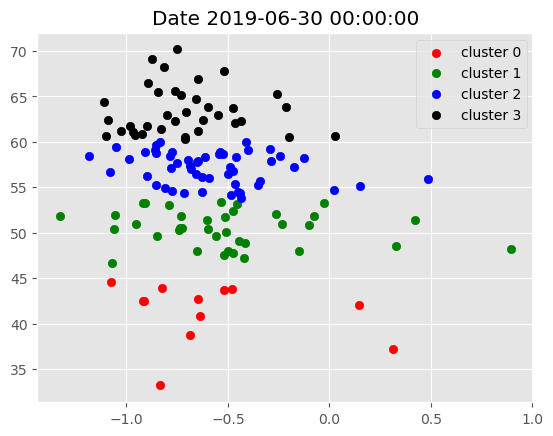

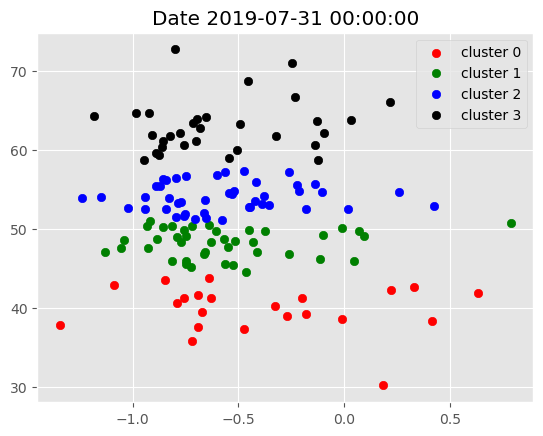

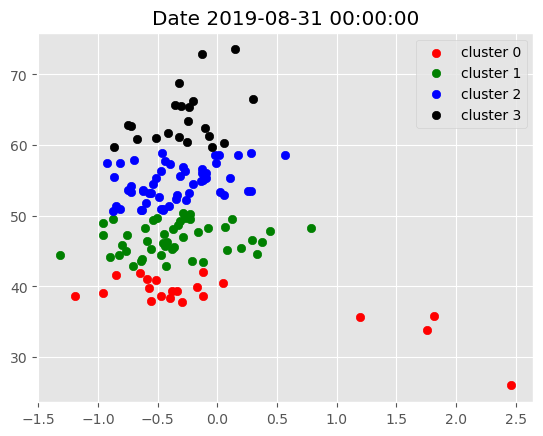

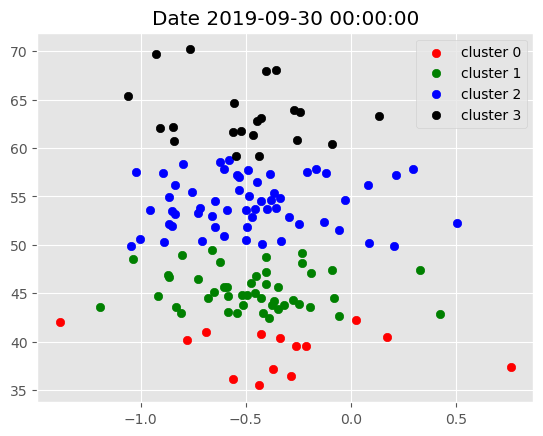

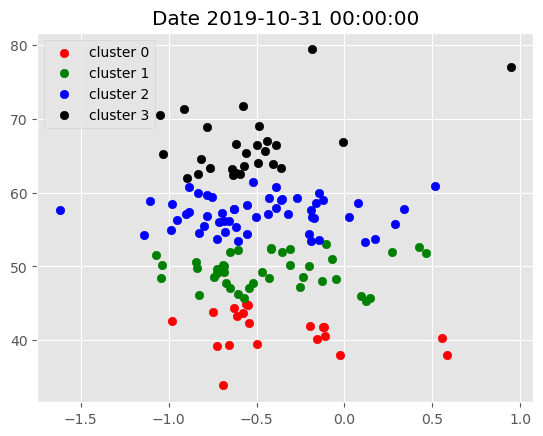

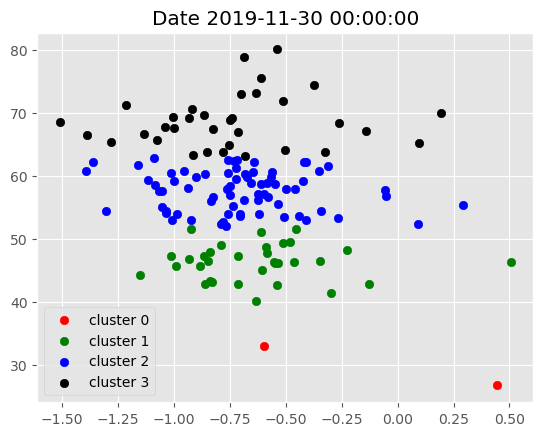

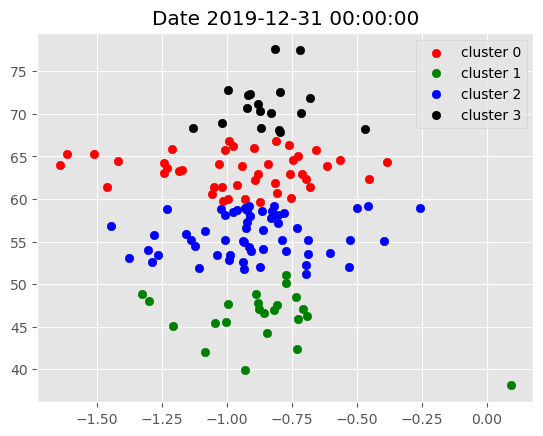

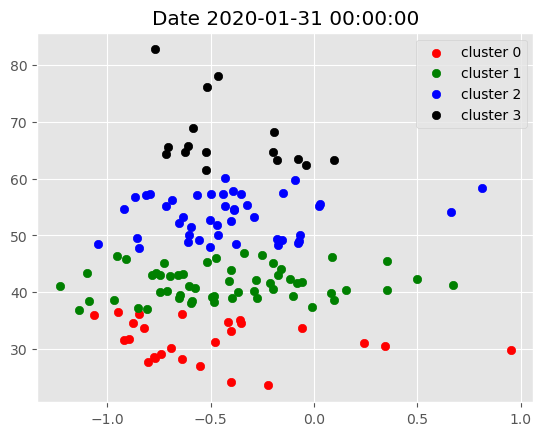

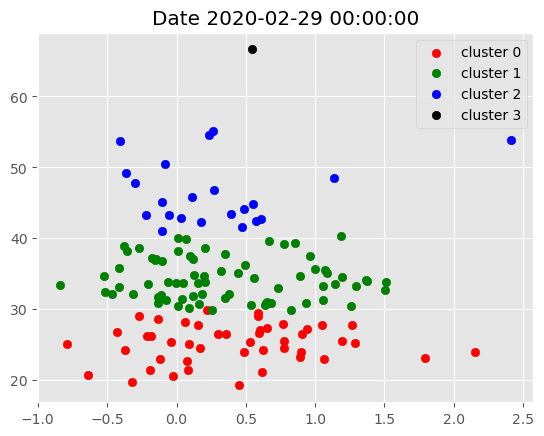

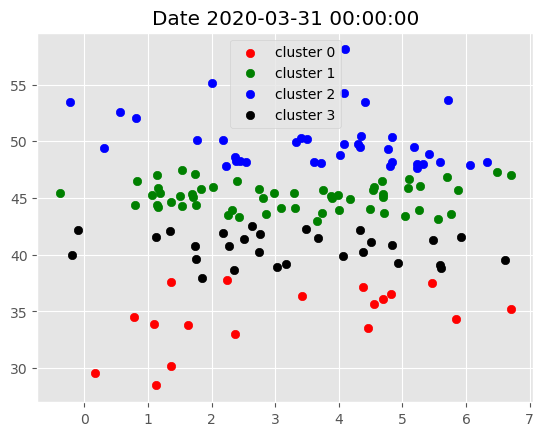

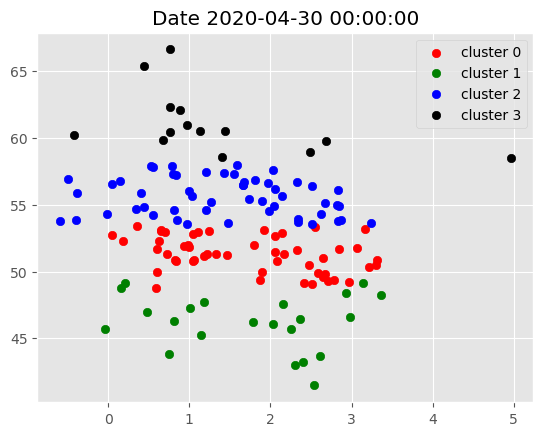

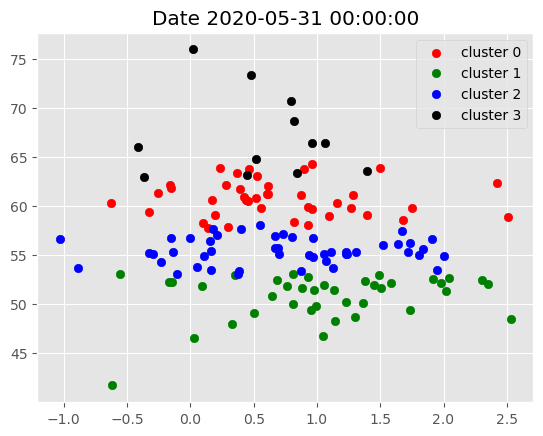

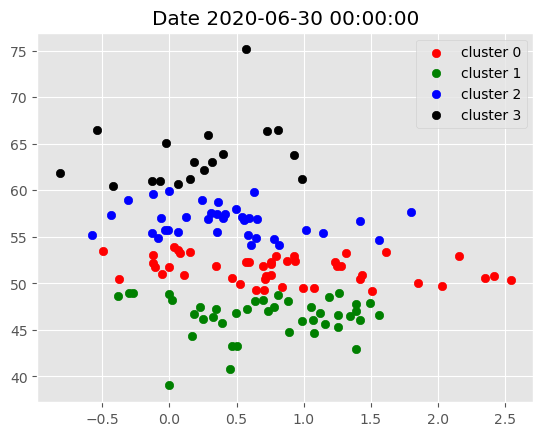

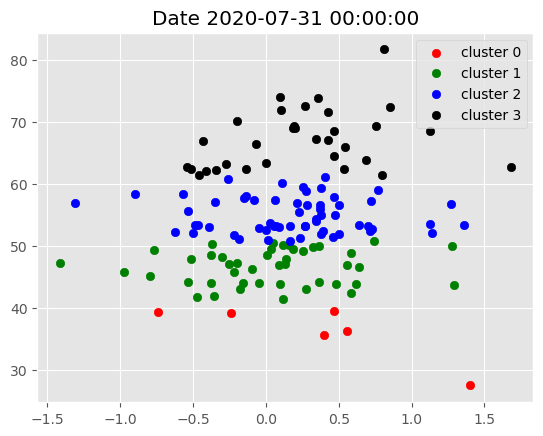

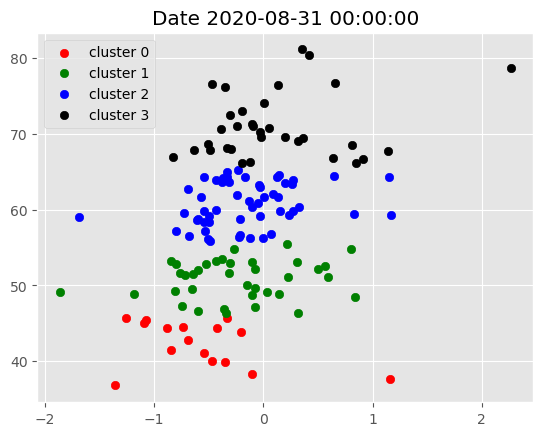

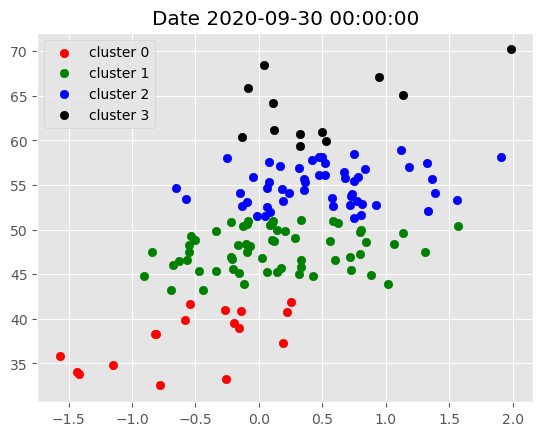

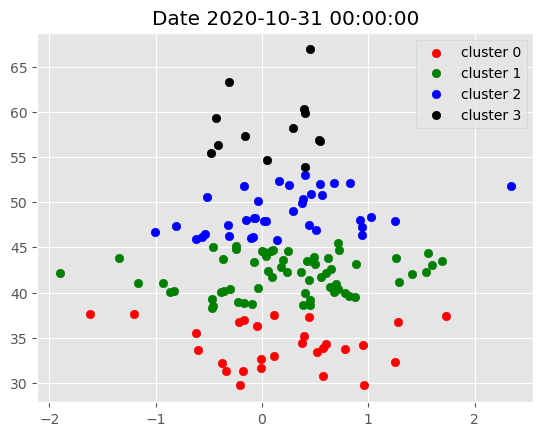

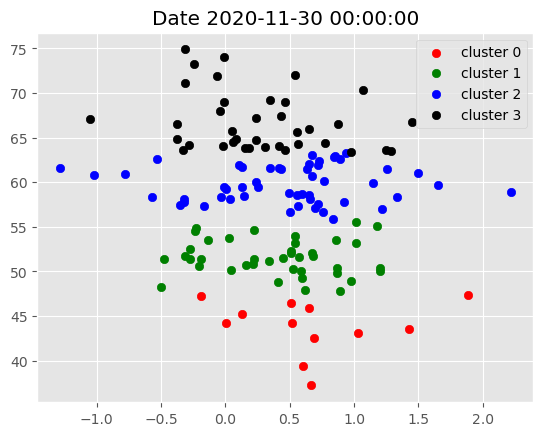

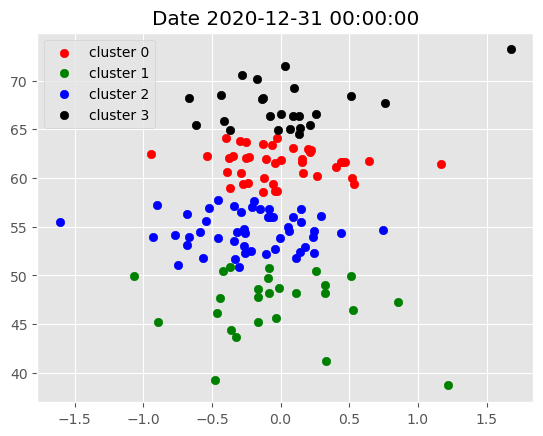

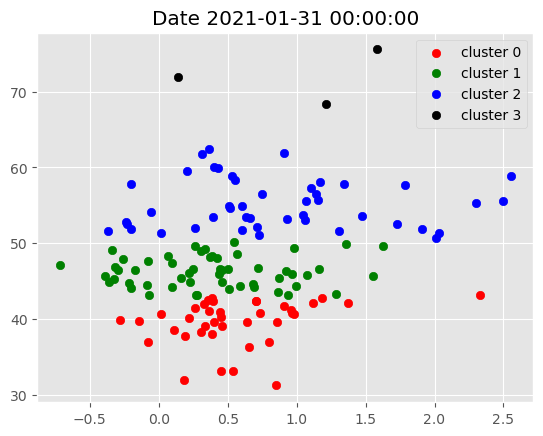

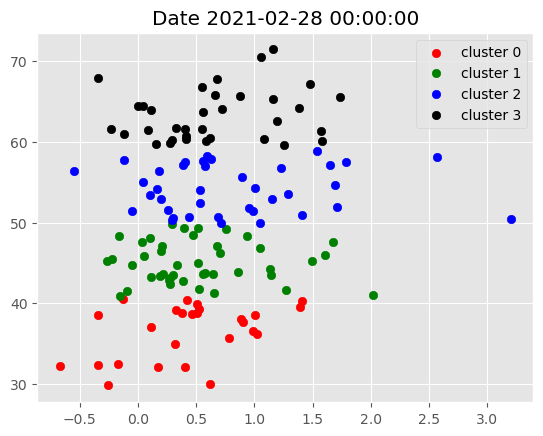

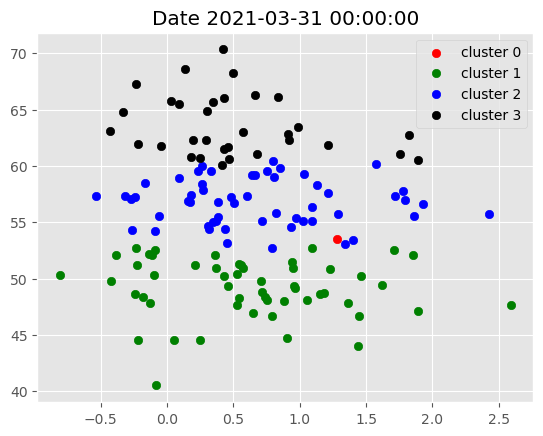

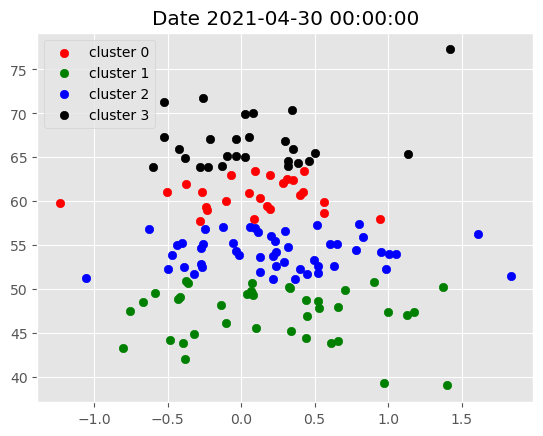

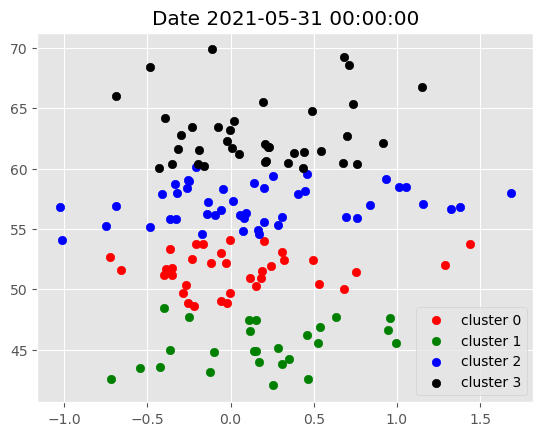

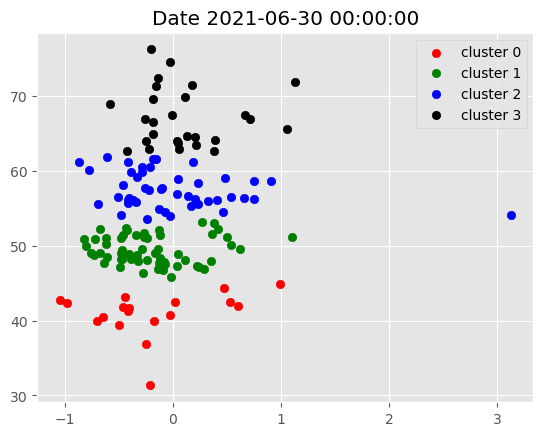

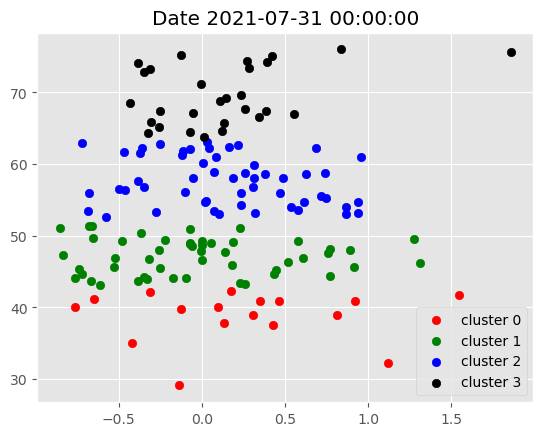

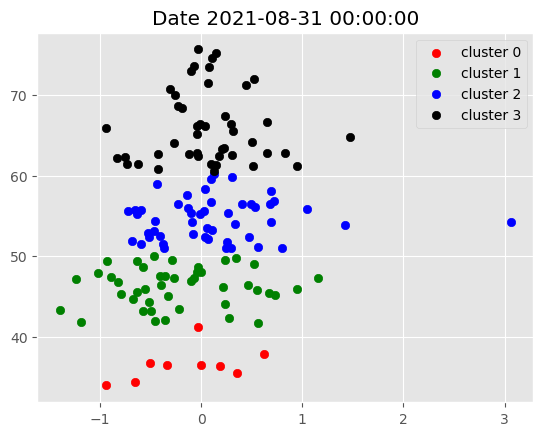

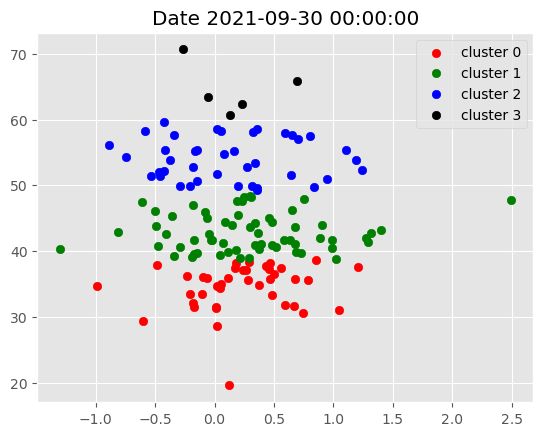

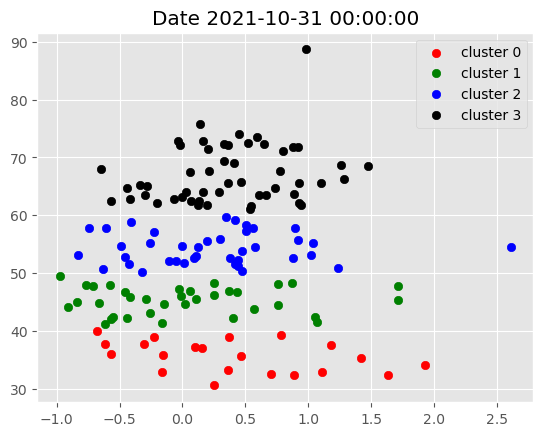

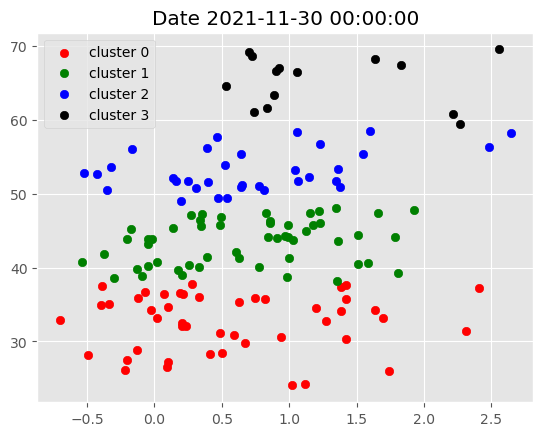

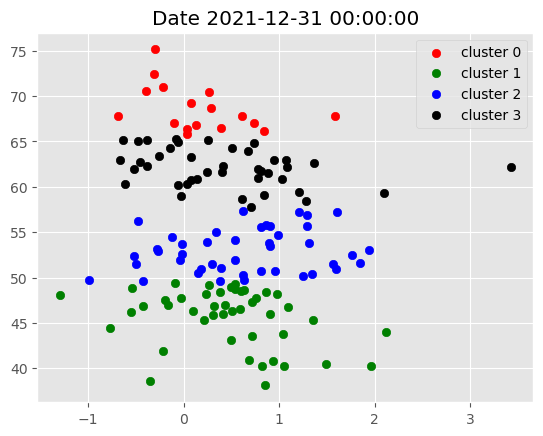

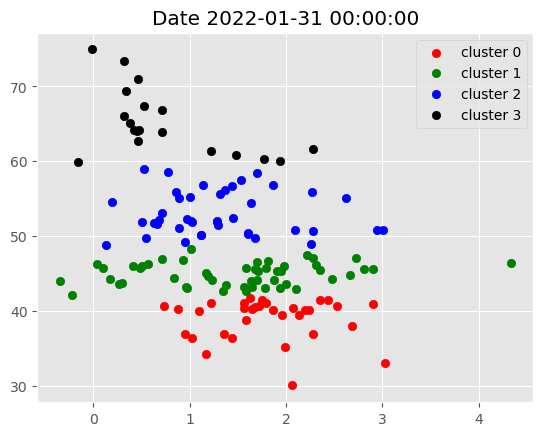

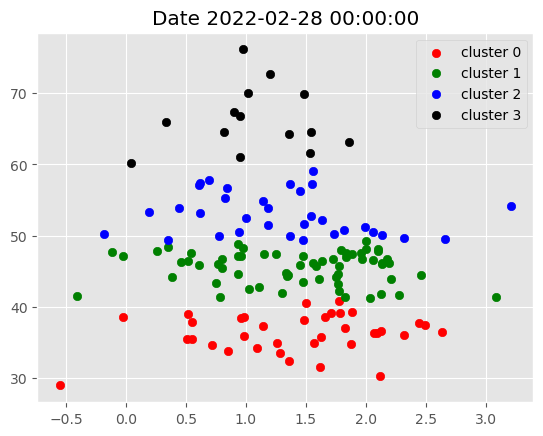

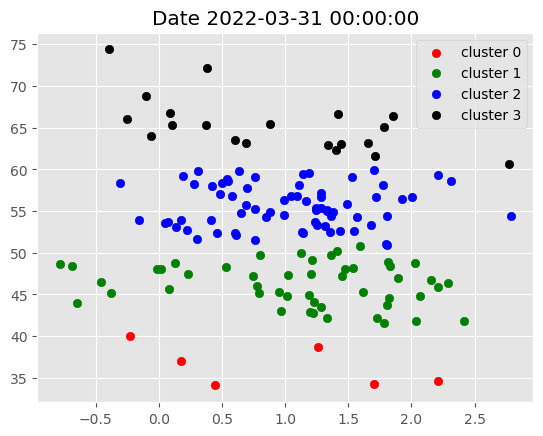

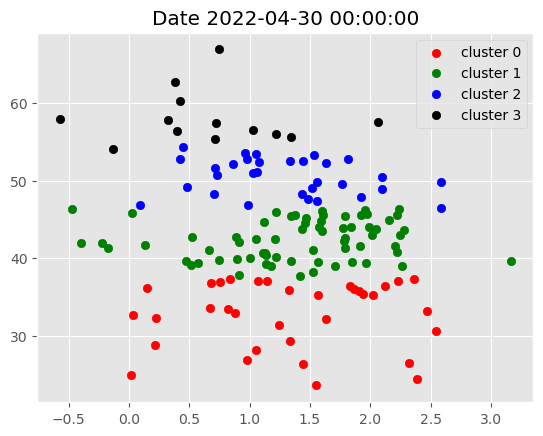

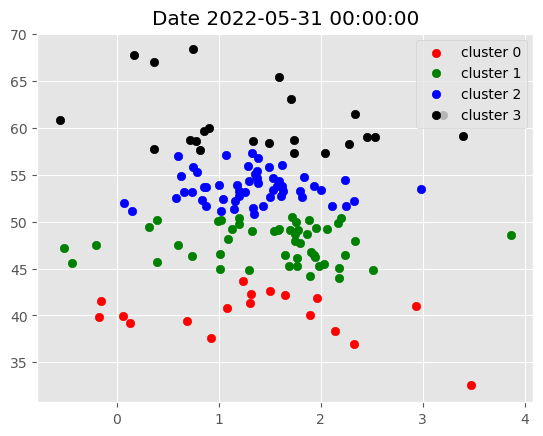

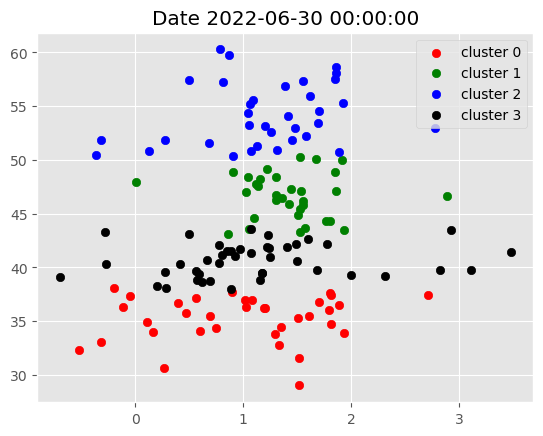

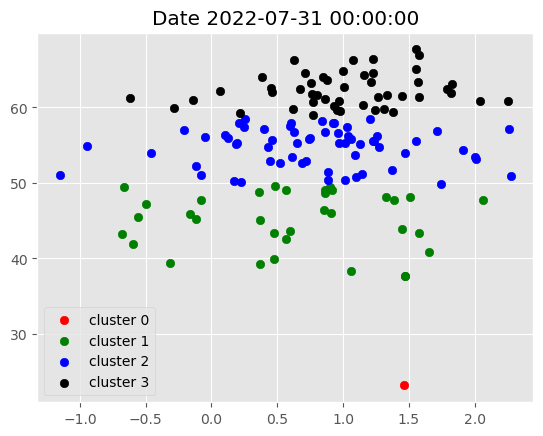

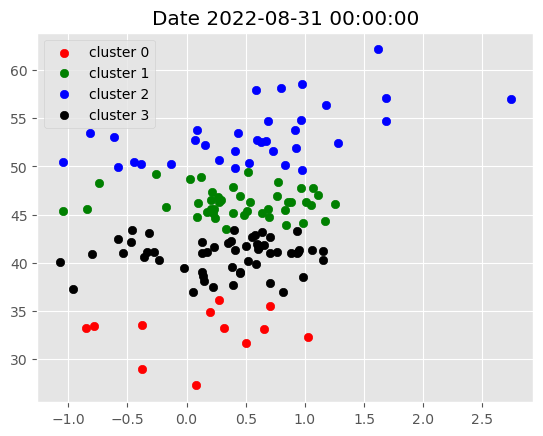

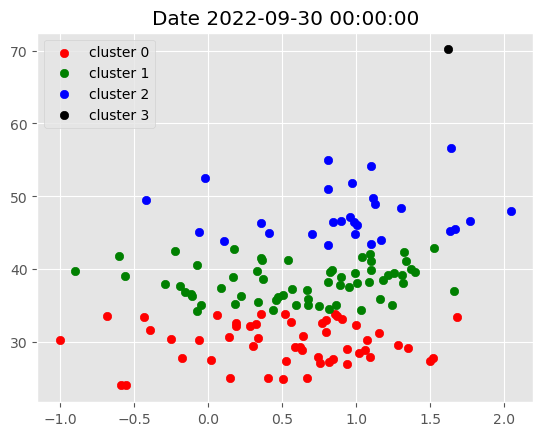

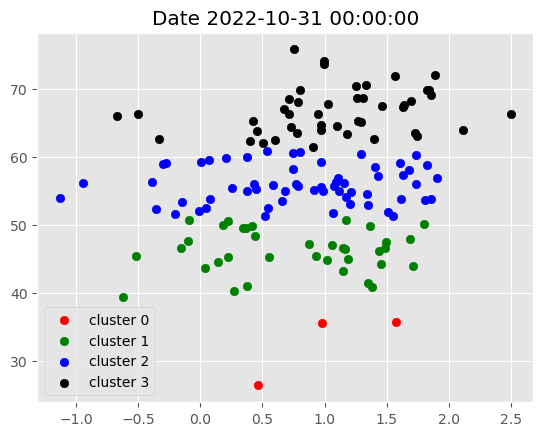

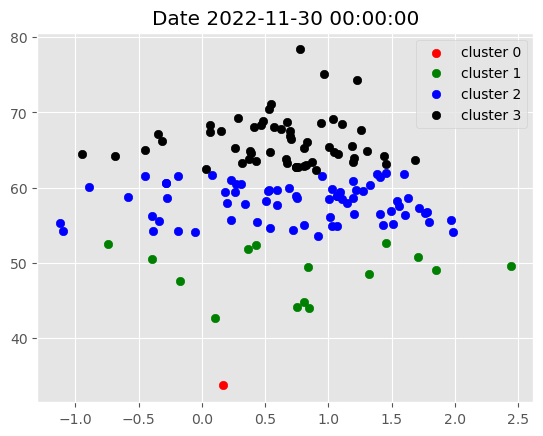

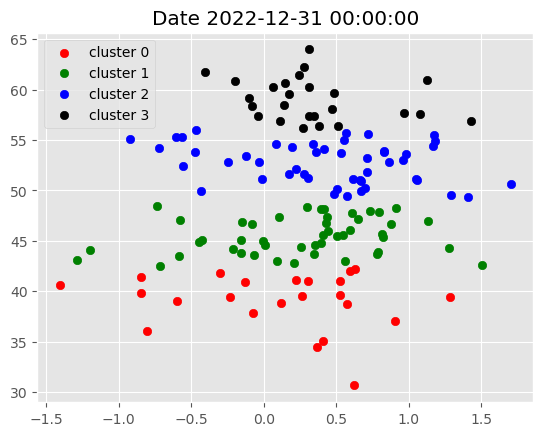

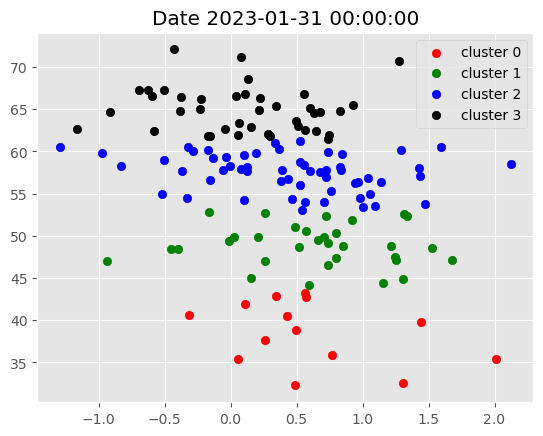

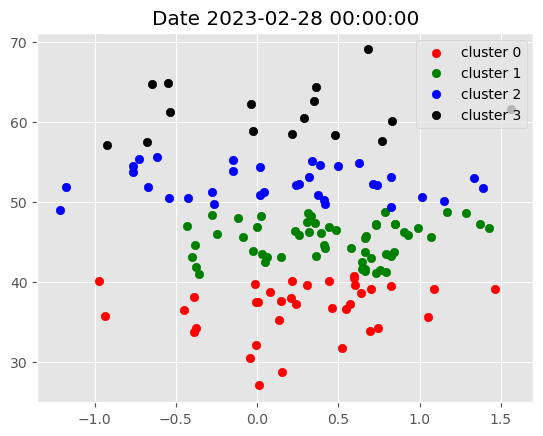

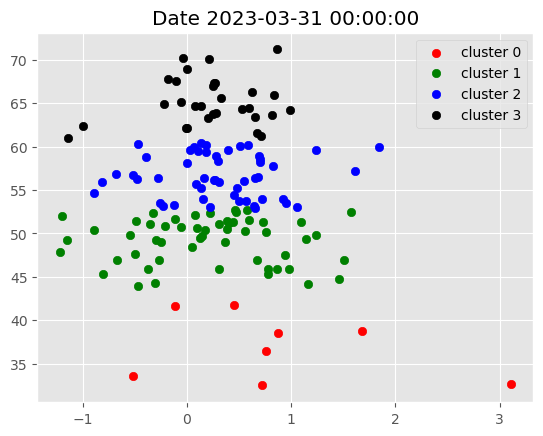

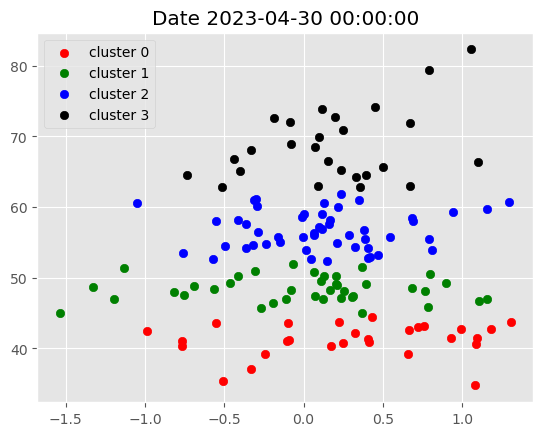

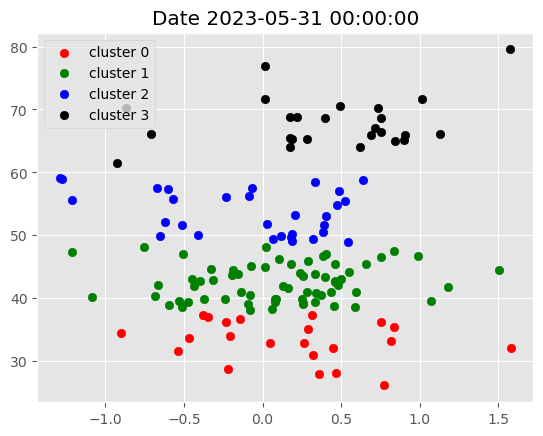

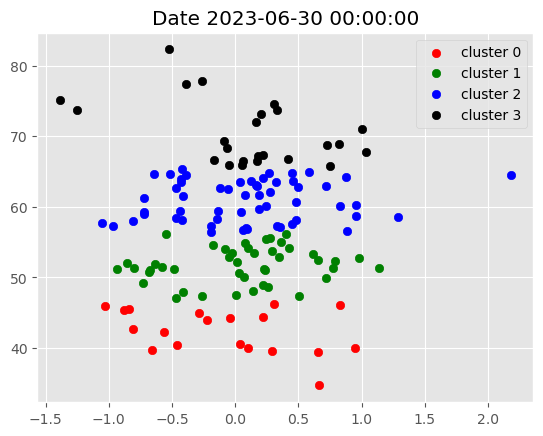

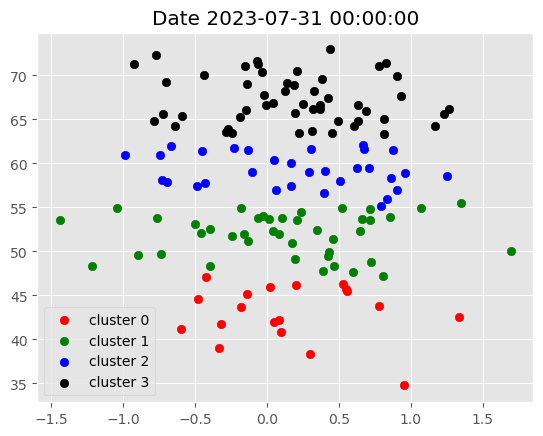

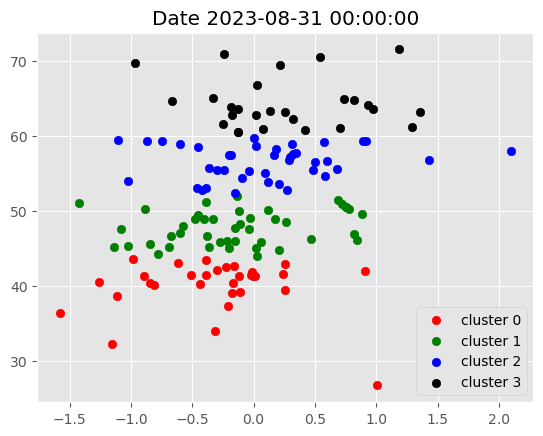

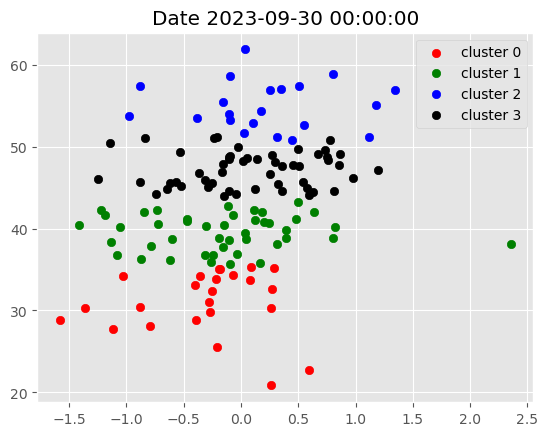

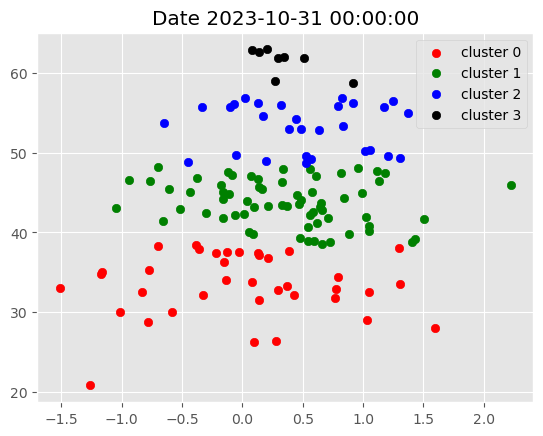

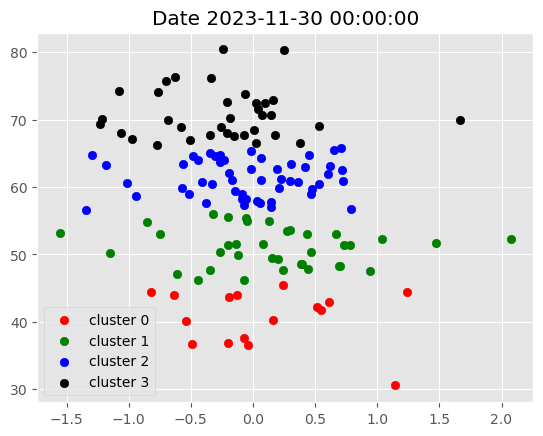

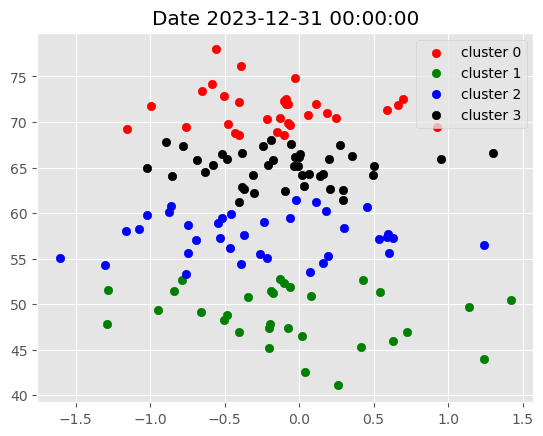

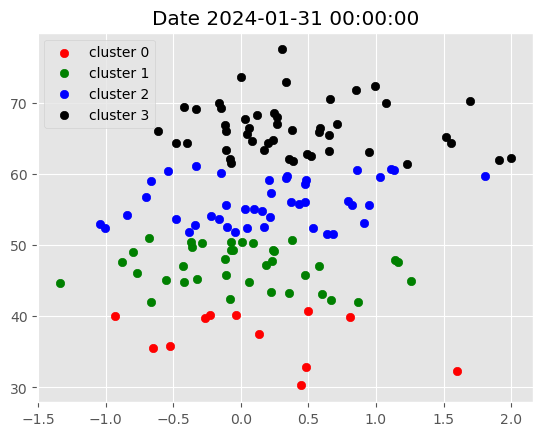

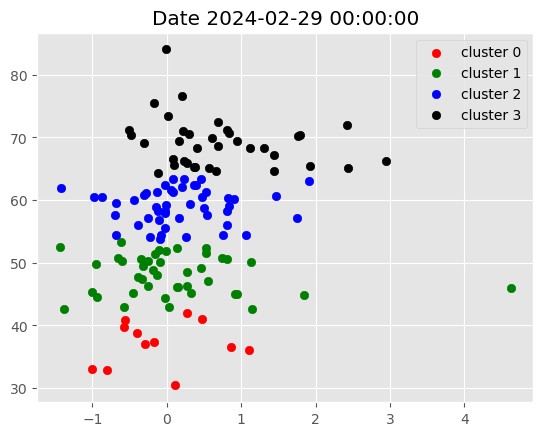

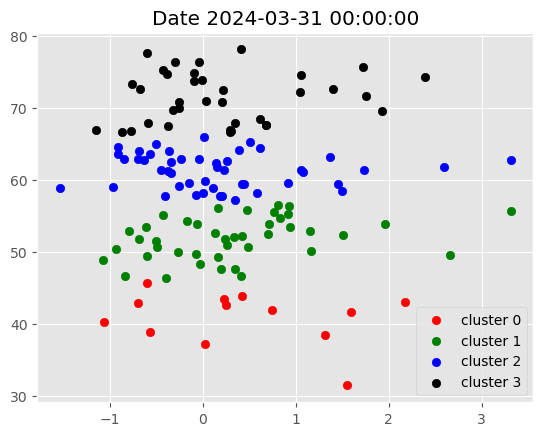

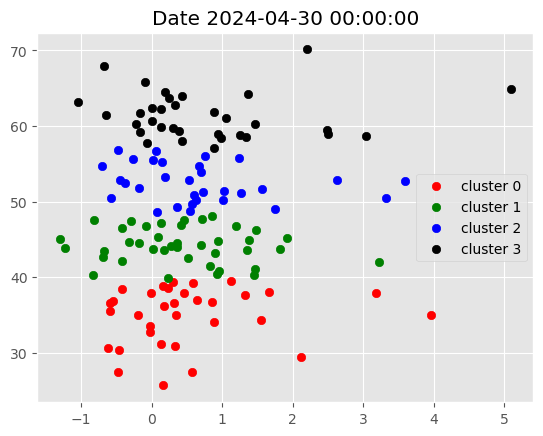

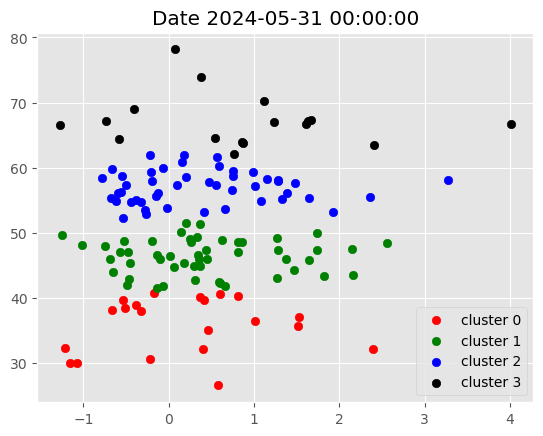

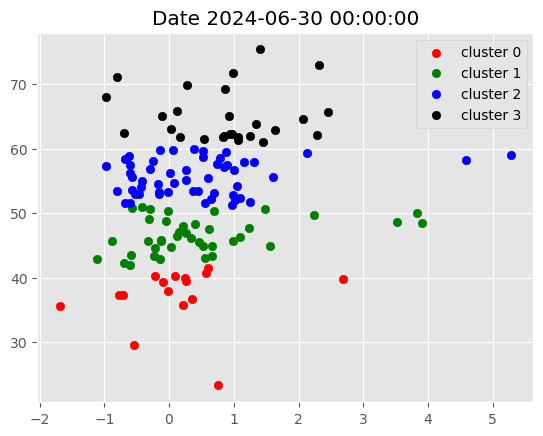

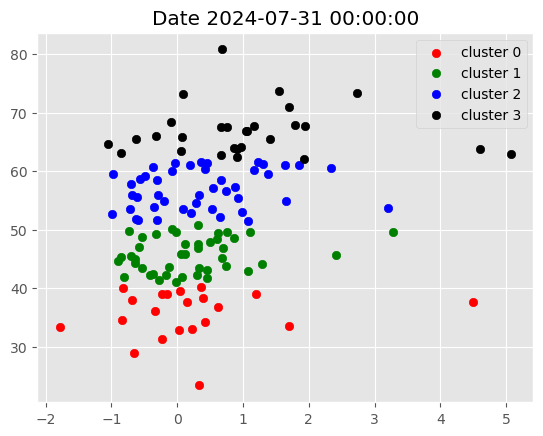

In [26]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

#Here we select cluster 3

# Select stocks based on cluster

In [27]:
#Main hypothesis is stocks >70 RSI have good momentum

filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1) #To go to 1st of next month

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ABT',
  'ACN',
  'ADP',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BDX',
  'CMCSA',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DAL',
  'DG',
  'ELV',
  'HUM',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'PFE',
  'PYPL',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'ULTA',
  'UNH',
  'UPS',
  'V',
  'VRTX',
  'WMT'],
 '2018-10-01': ['ABT',
  'ADP',
  'ADSK',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',

In [28]:
#Portfolio optimization function

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices, #Covariance
                                 frequency=252)
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound,0.1), #at max stock can have 10% weight overall
                           solver='SCS')
    weights = ef.max_sharpe() #optimized max sharpe ratio weights
    return ef.clean_weights()

In [29]:
#Download fresh daily prices data only for shortlisted stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-07-31  48.955448   34.805634   51.445618   43.532558  115.462822   
2017-08-01  49.557198   35.114544   51.791470   43.506008  116.394989   
2017-08-02  48.965160   36.773739   52.034309   43.576817  115.283562   
2017-08-03  49.062206   36.406319   52.240372   43.514862  116.538368   
2017-08-04  49.304859   36.598221   52.240372   43.603367  116.699715   
...               ...         ...         ...         ...         ...   
2024-07-12  10.680000  230.539993  168.729996  103.670006  310.630005   
2024-07-15  10.630000  234.399994  168.029999  102.959999  317.869995   
2024-07-16  11.190000  234.820007  169.199997  102.720001  325.000000   
2024-07-17  11.010000  228.880005  175.270004  104.680000  325.600006   
2024-07-18  10.620000  224.179993  171.139999  100.070000  328.100006   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-31  146.490005   69.072243  102.579727  110.790001  54.342339  ...   
2017-08-01  147.360001   69.019798  100.742256  111.379997  54.367252  ...   
2017-08-02  147.130005   68.906158   99.422379  109.129997  54.715969  ...   
2017-08-03  147.789993   68.136856   96.420273  107.879997  54.848812  ...   
2017-08-04  147.710007   67.996964   96.092461  108.389999  54.035130  ...   
...                ...         ...         ...         ...        ...  ...   
2024-07-12  559.049988  238.559998  238.020004  253.449997  77.139999  ...   
2024-07-15  565.710022  237.720001  242.639999  253.169998  77.620003  ...   
2024-07-16  566.539978  243.330002  245.820007  253.820007  78.290001  ...   
2024-07-17  563.090027  235.610001  249.250000  250.179993  78.580002  ...   
2024-07-18  556.849976  238.990005  247.399994  242.809998  78.059998  ...   

Price        Volume                                                            \
Ticker            V      VLO     VRTX        VZ       WBA       WDC       WFC   
Date                                                                            
2017-07-31  7576600  7354800  2972700  28456800   4853500   5093600  20378100   
2017-08-01  6018100  5330100  1621100  33498200   4892600   4010000  19350300   
2017-08-02  5955600  3724900  1781700  19233400   4216400   3757500  19422100   
2017-08-03  5697500  3342700  1407100  15190100   4666500   3511100  19374700   
2017-08-04  4618000  3201800   807800  13841700   3777300  10704300  44664600   
...             ...      ...      ...       ...       ...       ...       ...   
2024-07-12  6625700  2311200   839700  11126500  17198700   4553900  53029100   
2024-07-15  6845200  2442100   827600  15874900  20644700   5405400  27277300   
2024-07-16  7869900  2483300   813000  16016900  23536100   4257000  25577300   
2024-07-17  5324700  4185200  1697300  20401700  17911000  10699900  17371100   
2024-07-18  5547300  2327400  1472700  15751000  19790100   8726600  17735800   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-07-31  18789600  2475300  12820200  
2017-08-01  17179500  2424100  10421200  
2017-08-02  26019000  2906300  10410100  
2017-08-03  29840700  1238600  10136700  
2017-08-04  21425400  1034400   8292200  
...              ...      ...       ...  
2024-07-12  12140000  1776200  11680300  
2024-07-15  10171100  1868800  13032500  
2024-07-16   9836800  2010500  13614100  
2024-07-17  13533800  2042200  13602800  
2024-07-18  10680000  2317600  13030400  

[1753 rows x 930 columns]

# Calculate the daily returns for each stock and then calculate weights for next month

In [35]:
# #Calculate the daily returns for each stock and then calculate weights for next month

# returns_dataframe = np.log(new_df['Adj Close']).diff() #the difference & logarithm

# portfolio_df = pd.DataFrame()

# optimization_df = new_df['2017-08-01':'2018-07-31']['Adj Close'][fixed_dates['2018-08-01']]


# end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

# cols = fixed_dates[start_date] #stocks

# optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
# optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=12)).strftime('%Y-%m-%d')

# weights = optimize_weights(prices=optimization_df,
#                            lower_bound=round(1/len((optimization_df.columns)*2),2))

# weights = pd.DataFrame(weights, index=pd.Series(0))

# temp_df = returns_dataframe[start_date:end_date]

# temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
#                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
#                       left_index=True,
#                       right_index=True)\
#                .reset_index().set_index(['Date', 'index']).unstack().stack()


In [69]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            pass
#             print(f'Equal weights for {start_date}')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        pass

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Strategy Return
date                       
2018-08-01        -0.008687
2018-08-02         0.005925
2018-08-03         0.002510
2018-08-06         0.003395
2018-08-07         0.003835
...                     ...
2024-07-12         0.006028
2024-07-15         0.003550
2024-07-16         0.003129
2024-07-17        -0.014597
2024-07-18        -0.018903

[1500 rows x 1 columns]

# Benchmark the returns

In [70]:
spy = yf.download(tickers='SPY',
                  start='2018-08-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2018-08-02         0.005925      0.005433
2018-08-03         0.002510      0.004275
2018-08-06         0.003395      0.003661
2018-08-07         0.003835      0.003297
2018-08-08        -0.000395     -0.000421
...                     ...           ...
2024-07-12         0.006028      0.006288
2024-07-15         0.003550      0.002746
2024-07-16         0.003129      0.005913
2024-07-17        -0.014597     -0.014120
2024-07-18        -0.018903     -0.007715

[1499 rows x 2 columns]

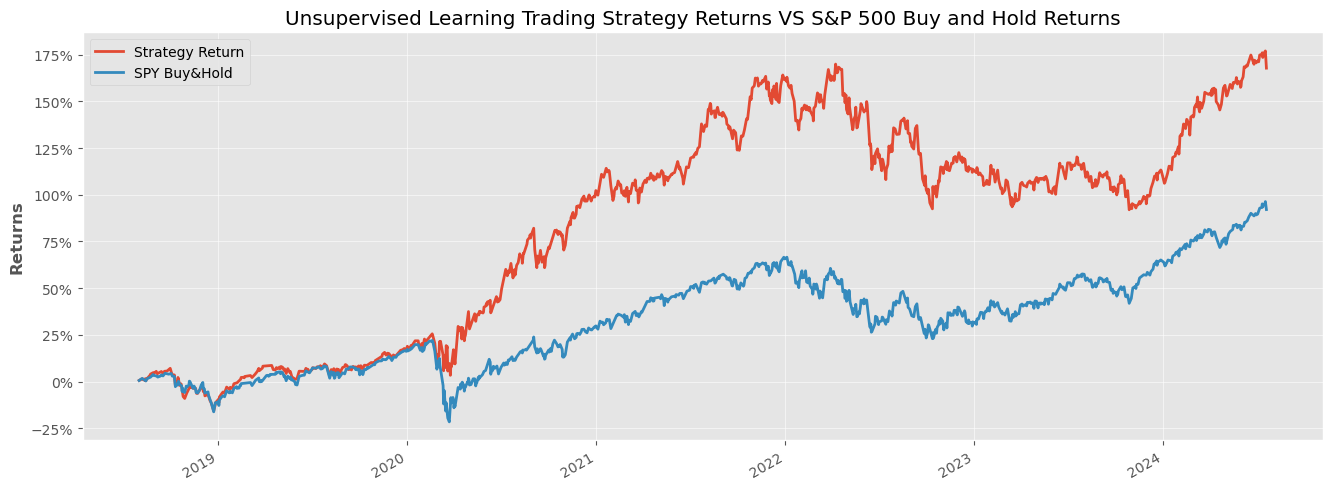

In [73]:
#Plot alongside
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-07-18'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns VS S&P 500 Buy and Hold Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Returns')

plt.show()

In [1]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick

# portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1

# plt.style.use('dark_background')
# fig, ax = plt.subplots(figsize=(24, 14))  

# portfolio_cumulative_return[:'2024-07-18'].plot(ax=ax, linewidth=4) 

# ax.set_title('Unsupervised Learning Trading Strategy\nvs S&P 500 Buy and Hold', fontsize=32, fontweight='bold', pad=20)
# ax.set_xlabel('Date', fontsize=28, labelpad=20)
# ax.set_ylabel('Cumulative Returns', fontsize=28, labelpad=20)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.tick_params(axis='both', which='major', labelsize=24)

# ax.grid(True, linestyle='--', alpha=0.6, linewidth=2)

# ax.legend(['Strategy Return', 'S&P 500 Buy & Hold'], loc='upper left', frameon=True, framealpha=0.9, fontsize=26)

# for column in portfolio_cumulative_return.columns:
#     start_value = portfolio_cumulative_return[column].iloc[0]
#     end_value = portfolio_cumulative_return[column].iloc[-1]
#     ax.annotate(f'Start: {start_value:.2%}', xy=(portfolio_cumulative_return.index[0], start_value), 
#                 xytext=(20, 20), textcoords='offset points', ha='left', va='bottom',
#                 bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.5),
#                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', lw=2),
#                 fontsize=22)
#     ax.annotate(f'End: {end_value:.2%}', xy=(portfolio_cumulative_return.index[-1], end_value), 
#                 xytext=(-20, -20), textcoords='offset points', ha='right', va='top',
#                 bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.5),
#                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', lw=2),
#                 fontsize=22)

# plt.tight_layout()
# plt.show()